# <font color=black> Analysis - ICA vs iCAP in the spinal cord </font>
<hr style="border:1px solid black">

**The goal of this analysis is to investigate the reproducibility of spinal networks extracted using different methods and datasets.**

**METHODS CONSIDERED:**
- Independent Component Analysis – called `ica` in this script
- Innovation-driven CoActivation Pattern analysis – called `icap` in this script

**DATASETS:**
- A dataset covering C1 to C8 spinal levels, with a resolution of 1.6x1.6x4mm<sup>3</sup>  and a TR of 1.55s – called `mtl` in this script
- A dataset covering C5 to C8 spinal levels, with a resolution of 1x1x3mm<sup>3</sup> and a TR of 2.5s – called `gva` in this script

**ANALYSES:**
- _**Qualitative:**_ matching & visualization of one or two set(s) of components
- _**Quantitative:**_
    * Analysis of spatial similarity (for a single K, or across multiple Ks)
    * Distribution across axial subdvisions (D,V,L,R) for different Ks

In [2]:
import sys,json
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns
import os 
from matplotlib import pyplot as plt

#sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')
sys.path.append('/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/code/')

from plotting import Plotting
from spine_only_analysis import SpineOnlyAnalysis
from compute_similarity import compute_similarity
%matplotlib inline
%load_ext autoreload
%autoreload 2

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


<hr style="border:1px solid black">

# Initialization

### Load configuration file 

In [3]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../../config/config_spine_only_CL.json') as config_file:
    config = json.load(config_file)
    
#with open('../config/config_spine_only_CL.json') as config_file:
#    config = json.load(config_file)
    

<hr style="border:1px solid black">

# Figure 1 – Defining number of components

## Stability across subsampling
Here, we take 100 subsamples of 10 subjects and assess the similarity with respect to the entire group

In [313]:
# Initializing parameters
methods = ['ica','icap']
datasets = ['gva']
nperm = 100
nsub = '5'
save_df = True
load_from_df = False

if load_from_df==True and os.path.isfile(config['main_dir'] + config['output_dir'] + 'perm_df_' + config['output_tag'] + '_' +  nsub + 'sub.csv'):
    perm_df = pd.read_csv(config['main_dir'] + config['output_dir'] + 'perm_df_' + config['output_tag'] + '_' +  nsub + 'sub.csv',delimiter=" ")
else:
    # Create structure to save results
    all_methods = []
    all_datasets = []
    all_kmax = []
    all_sim = []
    all_n = []
    # For each method & dataset
    for method in methods:
        for dataset in datasets:
            krange = range(7,12) if dataset == 'mtl' else range(3,8)
            print(f'Computing stability for {method} in {dataset}')
            # Looping through K and permutations
            for k_i,kmax in enumerate(krange):
                print(f'K = {kmax}')
                 # Load reference data (entire group)
                data_ref = nib.load(glob.glob(config['main_dir']+config['data'][dataset][method]['spinalcord']['dir'] + '/K_' + str(kmax) + '/comp_zscored/*' + config['data'][dataset][method]['spinalcord']["tag_filename"] + '*')[0]).get_fdata()
                for n in range(0,nperm):
                    all_methods.append(method)
                    all_datasets.append(dataset)
                    all_kmax.append(kmax)
                    all_n.append(n)
                    # Load permutation data
                    data_perm = nib.load(glob.glob(config['main_dir']+config['data'][dataset][method + '_perm']['spinalcord']['dir'][nsub] + str(n+1) + '*/K_' + str(kmax) + '*/' + config['data'][dataset][method + '_perm']['spinalcord']['comp_folder'] + '/*' + config['data'][dataset][method + '_perm']['spinalcord']["tag_filename"] + '*.nii*')[0]).get_fdata()            
                    # Compute similarity matrix between perm data and ref 
                    [tmp_mat,_,_] = compute_similarity(config,data_ref,data_perm,method='Dice',thresh1=1.6,thresh2=1.6,verbose=False)
                    # Take mean of the diagonal as a summary measure of similarity
                    all_sim.append(np.mean(np.diag(tmp_mat)))
    colnames = ["method","dataset","kmax","perm","sim"]
    perm_df = pd.DataFrame(list(zip(all_methods, all_datasets, all_kmax, all_n, all_sim)), columns=colnames)
    if save_df == True:
        perm_df.to_csv(config['main_dir'] + config['output_dir'] + 'perm_df_' + config['output_tag'] + '_' +  nsub + 'sub.csv', sep=' ', index=False)

Computing stability for ica in gva
K = 3
K = 4
K = 5
K = 6
K = 7
Computing stability for icap in gva
K = 3
K = 4
K = 5
K = 6
K = 7


## `MTL` dataset

<Figure size 432x288 with 0 Axes>

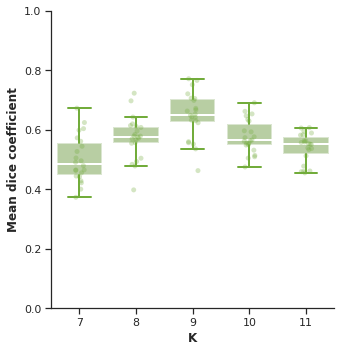

In [227]:
dataset='mtl'
colors=["#72ac3bff","#72ac3bff"]
sns.set(style="ticks",  font='sans-serif')

for method_ind, method in enumerate(methods):
    plt.figure(method_ind)
    g=sns.catplot(y="sim",x="kmax",data=perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method)], kind="box", legend=True, legend_out=True,
                 linewidth=2,medianprops=dict(color="white"),color=colors[method_ind], 
                 boxprops=dict(alpha=.5,edgecolor=None),whiskerprops=dict(color=colors[method_ind]), capprops=dict(color=colors[method_ind]), fliersize=0, aspect=1) #fliersize=0)
    g.set(ylim=(0, 1),xlim=(7,11))
    g.fig.set_size_inches(5,5)
    sns.stripplot(y="sim",x="kmax",data=perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method)],
                 size=5, color=colors[method_ind], alpha=.3, linewidth=0,edgecolor='white',dodge=True)
    
    g.set_axis_labels("K", "Mean dice coefficient",fontsize=12, fontweight='bold')
    g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_subsampling_stability_' + dataset + '_' + method+ '_' +  nsub + 'sub.pdf', format='pdf')

## `GVA` dataset

<Figure size 432x288 with 0 Axes>

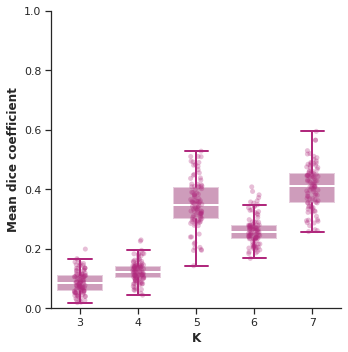

In [314]:
dataset='gva'
colors=["#b0297dff","#b0297dff"]
sns.set(style="ticks",  font='sans-serif')
for method_ind, method in enumerate(methods):
    plt.figure(method_ind)
    g=sns.catplot(y="sim",x="kmax",data=perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method)], kind="box", legend=True, legend_out=True,
                 linewidth=2,medianprops=dict(color="white"),color=colors[method_ind], 
                 boxprops=dict(alpha=.5,edgecolor=None),whiskerprops=dict(color=colors[method_ind]), capprops=dict(color=colors[method_ind]), fliersize=0, aspect=1) #fliersize=0)
    g.fig.set_size_inches(5,5)
    g.set(ylim=(0, 1),xlim=(3,7))
    sns.stripplot(y="sim",x="kmax",data=perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method)],
                 size=5, color=colors[method_ind], alpha=.3, linewidth=0,edgecolor='white',dodge=True)
    g.set_axis_labels("K", "Mean dice coefficient",fontsize=12, fontweight='bold')
    g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_subsampling_stability_' + dataset + '_' + method+ '_' +  nsub + 'sub.pdf', format='pdf')

## Summary of values

In [298]:
for dataset in ['mtl','gva']:
    for method in ['ica', 'icap']:
        print(f"Dataset: {dataset} - Method: {method}")
        for k in range(7,12) if dataset == 'mtl' else range(3,8):
            print(f"K={k} - Median {np.round(perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method) & (perm_df['kmax']==k)]['sim'].median(),2)} - IQR: {np.round(perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method) & (perm_df['kmax']==k)]['sim'].quantile(0.75)-perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method) & (perm_df['kmax']==k)]['sim'].quantile(0.25),2)}")

Dataset: mtl - Method: ica
K=7 - Median 0.57 - IQR: 0.1
K=8 - Median 0.65 - IQR: 0.11
K=9 - Median 0.75 - IQR: 0.1
K=10 - Median 0.68 - IQR: 0.08
K=11 - Median 0.58 - IQR: 0.07
Dataset: mtl - Method: icap
K=7 - Median 0.87 - IQR: 0.19
K=8 - Median 0.91 - IQR: 0.06
K=9 - Median 0.92 - IQR: 0.03
K=10 - Median 0.89 - IQR: 0.1
K=11 - Median 0.86 - IQR: 0.13
Dataset: gva - Method: ica
K=3 - Median 0.11 - IQR: 0.08
K=4 - Median 0.18 - IQR: 0.07
K=5 - Median 0.4 - IQR: 0.14
K=6 - Median 0.29 - IQR: 0.08
K=7 - Median 0.51 - IQR: 0.11
Dataset: gva - Method: icap
K=3 - Median 0.83 - IQR: 0.03
K=4 - Median 0.86 - IQR: 0.2
K=5 - Median 0.9 - IQR: 0.04
K=6 - Median 0.87 - IQR: 0.12
K=7 - Median 0.86 - IQR: 0.15


## Clustering stability (not used in paper)

In [35]:
ami_mtl = pd.read_csv(config['main_dir'] + config['output_dir'] + 'mtl_10sub.csv', names = [7,8,9,10,11])
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(data=ami_mtl, kind="box",  legend=True, legend_out=True,
             linewidth=2,color='#20b5bf', medianprops=dict(color="white"),
            boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(5,5)
sns.stripplot(data=ami_mtl, size=6, color='#20b5bf', alpha=1, linewidth=1,edgecolor='white',dodge=True)

g.set_axis_labels("K", "Adjusted Mutual Information",fontsize=12, fontweight='bold')

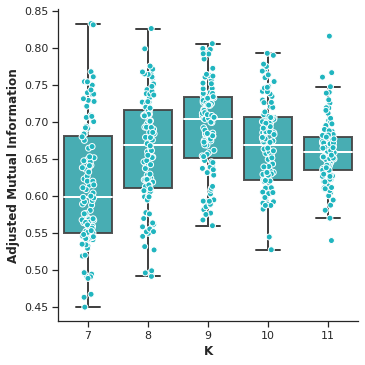

In [38]:
ami_mtl = pd.read_csv(config['main_dir'] + config['output_dir'] + 'mtl_5sub.csv', names = [7,8,9,10,11])
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(data=ami_mtl, kind="box",  legend=True, legend_out=True,
             linewidth=2,color='#20b5bf', medianprops=dict(color="white"),
            boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(5,5)
sns.stripplot(data=ami_mtl, size=6, color='#20b5bf', alpha=1, linewidth=1,edgecolor='white',dodge=True)

g.set_axis_labels("K", "Adjusted Mutual Information",fontsize=12, fontweight='bold')

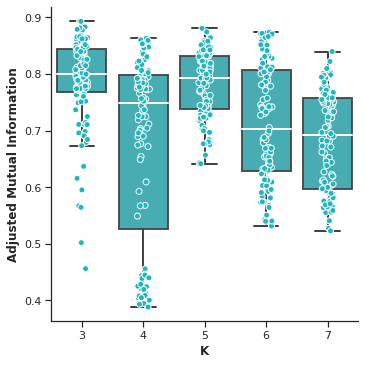

In [37]:
ami_gva = pd.read_csv(config['main_dir'] + config['output_dir'] + 'gva_10sub.csv', names = [3,4,5,6,7])
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(data=ami_gva, kind="box",  legend=True, legend_out=True,
             linewidth=2,color='#20b5bf', medianprops=dict(color="white"),
            boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(5,5)
sns.stripplot(data=ami_gva, size=6, color='#20b5bf', alpha=1, linewidth=1,edgecolor='white',dodge=True)

g.set_axis_labels("K", "Adjusted Mutual Information",fontsize=12, fontweight='bold')

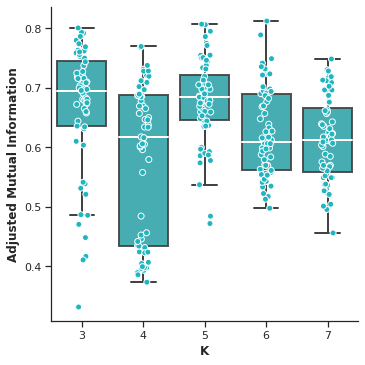

In [39]:
ami_gva = pd.read_csv(config['main_dir'] + config['output_dir'] + 'gva_5sub_60perm.csv', names = [3,4,5,6,7])
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(data=ami_gva, kind="box",  legend=True, legend_out=True,
             linewidth=2,color='#20b5bf', medianprops=dict(color="white"),
            boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(5,5)
sns.stripplot(data=ami_gva, size=6, color='#20b5bf', alpha=1, linewidth=1,edgecolor='white',dodge=True)

g.set_axis_labels("K", "Adjusted Mutual Information",fontsize=12, fontweight='bold')

<hr style="border:1px solid black">

# Figure 2 – Robustness (across methods)

## `GVA` dataset

### Qualitative evaluation

In [232]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_robustness_gva_ica = {'k':5, 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_qual_robustness_gva_icap = {'k':5, 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}

plotting_robustness_gva = Plotting(config,'spinalcord',params1=params_qual_robustness_gva_ica,params2=params_qual_robustness_gva_icap)

Sorting method: rostrocaudal (max value)
Sorting method: rostrocaudal (max value)


The plotting will be displayed in neurological orientation (Left > Right)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


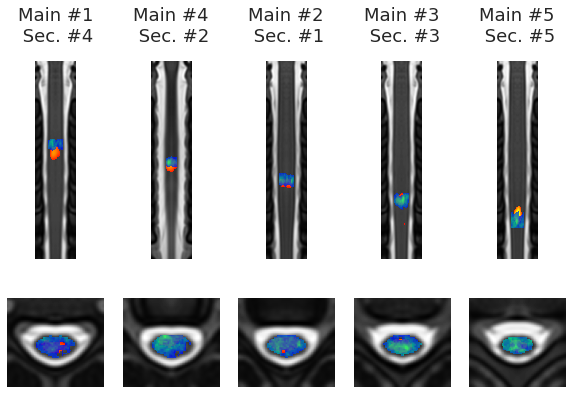

In [233]:
#plotting_robustness_gva.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice', template=config['main_dir']+'/templates/PAM50_hc_project/template/T2w_gva_group_mean_resampled.nii.gz')
plotting_robustness_gva.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')


_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation - Number of voxels & Dice

In [234]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_robustness_gva_ica = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_quant_robustness_gva_icap = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}

spine_analysis_robustness_gva = SpineOnlyAnalysis(config,params1=params_quant_robustness_gva_ica,params2=params_quant_robustness_gva_icap)

In [ ]:
spine_analysis_robustness_gva.extract_voxels_nb(K=5,params=params_quant_robustness_gva_ica) 
spine_analysis_robustness_gva.extract_voxels_nb(K=5,params=params_quant_robustness_gva_icap) 

METHOD 1: Comparing two sets of components at specific K values 
gva_ica at K = 5 vs gva_icap at K = 5 

Sorting method: rostrocaudal (max value)
The mean similarity is 0.42 ± 0.1


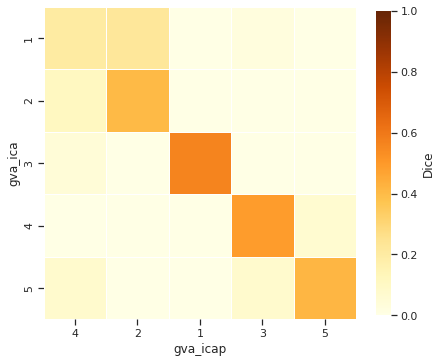

In [235]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_robustness_gva.spatial_similarity(k1=5,similarity_method='Dice',save_figure=True)

## `MTL` dataset

### Qualitative evaluation

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_robustness_mtl_ica = {'k':10, 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}
params_qual_robustness_mtl_icap = {'k':10, 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

plotting_robustness_mtl = Plotting(config,'spinalcord',params1=params_qual_robustness_mtl_ica,params2=params_qual_robustness_mtl_icap)

In [ ]:
#plotting_robustness_mtl.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice', template=config['main_dir']+'/templates/PAM50_hc_project/template/T2w_mtl_group_mean_resampled.nii.gz')
plotting_robustness_mtl.sc_plot(show_spinal_levels=False, k_per_line=10, lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

In [236]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_robustness_mtl_ica = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}
params_quant_robustness_mtl_icap = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

spine_analysis_robustness_mtl = SpineOnlyAnalysis(config,params1=params_quant_robustness_mtl_ica,params2=params_quant_robustness_mtl_icap)

In [ ]:
spine_analysis_robustness_mtl.extract_voxels_nb(K=9,params=params_quant_robustness_mtl_icap) 
spine_analysis_robustness_mtl.extract_voxels_nb(K=9,params=params_quant_robustness_mtl_ica) 

METHOD 1: Comparing two sets of components at specific K values 
mtl_ica at K = 9 vs mtl_icap at K = 9 

Sorting method: rostrocaudal (max value)
The mean similarity is 0.77 ± 0.1


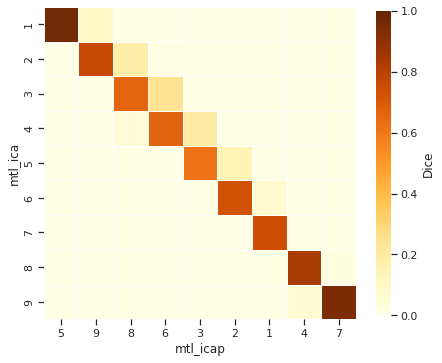

In [237]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_robustness_mtl.spatial_similarity(k1=9,similarity_method='Dice',save_figure=True)

<hr style="border:1px solid black">

# Figure 3 – Replicability (across datasets)

## `ICA` method

### Qualitative evaluation

In [109]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_replic_ica_gva = {'k':5, 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_qual_replic_ica_mtl = {'k':5, 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}

plotting_replicability_ica = Plotting(config,'spinalcord',params1=params_qual_replic_ica_gva,params2=params_qual_replic_ica_mtl)

Sorting method: rostrocaudal (max value)
Sorting method: rostrocaudal (max value)


The plotting will be displayed in neurological orientation (Left > Right)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


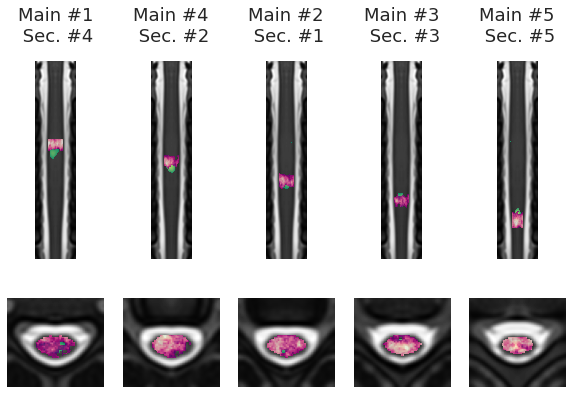

In [110]:
plotting_replicability_ica.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, save_results=True, colormap_two=['summer','RdPu_r'], similarity_method='Dice', centering_method='middle')

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_replic_ica_gva = {'k':5, 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_qual_replic_ica_mtl = {'k':9, 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}

plotting_replicability_ica = Plotting(config,'spinalcord',params1=params_qual_replic_ica_gva,params2=params_qual_replic_ica_mtl)

In [ ]:
plotting_replicability_ica.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=True, colormap_two=['summer','RdPu_r'], similarity_method='Dice', centering_method='middle')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

In [238]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_replicability_ica_gva = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'ica', 'lthresh':1.6}
params_quant_replicability_ica_mtl = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'ica', 'lthresh':1.6}

spine_analysis_replicability_ica = SpineOnlyAnalysis(config,params1=params_quant_replicability_ica_gva,params2=params_quant_replicability_ica_mtl)

METHOD 1: Comparing two sets of components at specific K values 
gva_ica at K = 5 vs mtl_ica at K = 9 

Sorting method: rostrocaudal (max value)
The mean similarity is 0.42 ± 0.1


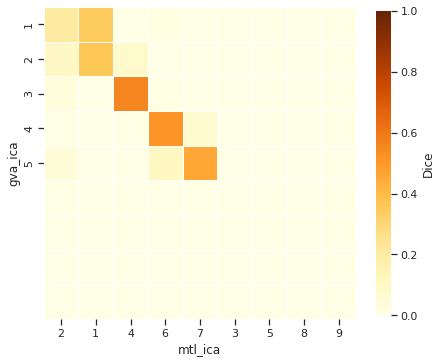

In [239]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_replicability_ica.spatial_similarity(k1=5,k2=9,similarity_method='Dice',save_figure=True)

## `iCAP` method

### Qualitative evaluation

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_replic_icap_gva = {'k':5, 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}
params_qual_replic_icap_mtl = {'k':9, 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

plotting_replicability_icap = Plotting(config,'spinalcord',params1=params_qual_replic_icap_gva,params2=params_qual_replic_icap_mtl)

In [ ]:
plotting_replicability_icap.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=True, colormap_two=['summer','RdPu_r'], similarity_method='Dice', centering_method='middle')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

In [240]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_replicability_icap_gva = {'k_range':range(5,6), 'dataset':'gva', 'analysis':'icap', 'lthresh':1.6}
params_quant_replicability_icap_mtl = {'k_range':range(9,10), 'dataset':'mtl', 'analysis':'icap', 'lthresh':1.6}

spine_analysis_replicability_icap = SpineOnlyAnalysis(config,params1=params_quant_replicability_icap_gva,params2=params_quant_replicability_icap_mtl)

METHOD 1: Comparing two sets of components at specific K values 
gva_icap at K = 5 vs mtl_icap at K = 9 

Sorting method: rostrocaudal (max value)
The mean similarity is 0.75 ± 0.2


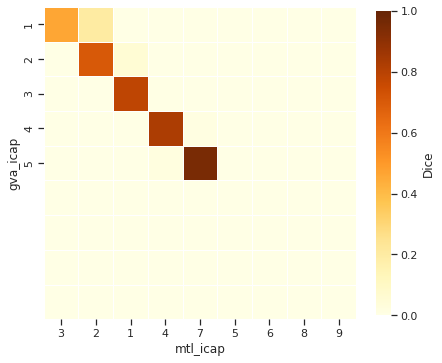

In [241]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_replicability_icap.spatial_similarity(k1=5,k2=9,similarity_method='Dice',save_figure=True)

<hr style="border:1px solid black">

# Figure 4 – Stability across splits

## `GVA` dataset

### Qualitative evaluation

Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)


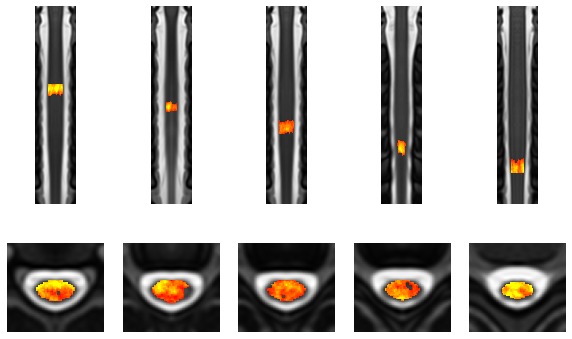

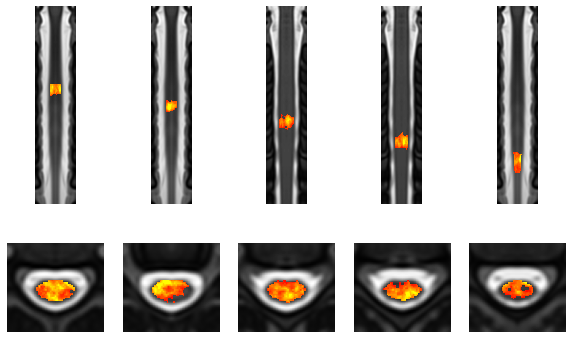

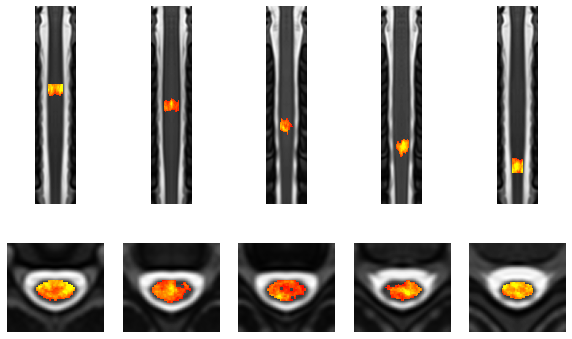

In [72]:
splits = ["quart1","quart2","quart3","quart4"]
dataset = 'gva'

for split in splits:
    params_qual_split_gva = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap_duration', 'duration':split}
    plotting_split_gva = Plotting(config,'spinalcord',params1=params_qual_split_gva)
    plotting_split_gva.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')

### Quantitative evaluation

### `iCAP` method

**Comparing splits with entire run**

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/15min/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart1/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart2/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart3/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart4/K_5/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.8978981773443145  ±  0.04
0.8153155827822796  ±  0.1
0.9166158965582933  ±  0.03
0.8931913827477478  ±  0.04


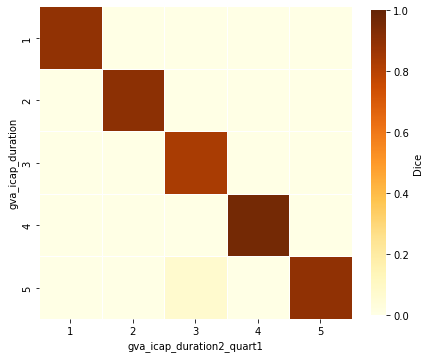

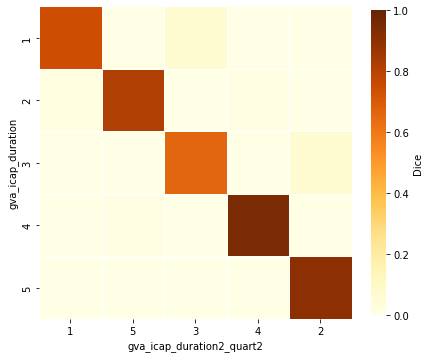

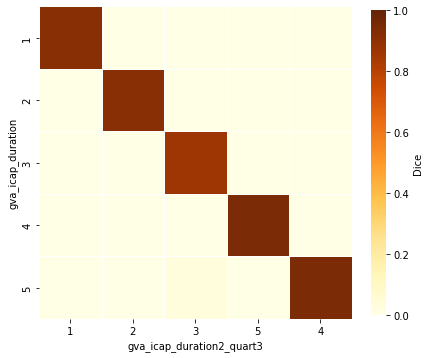

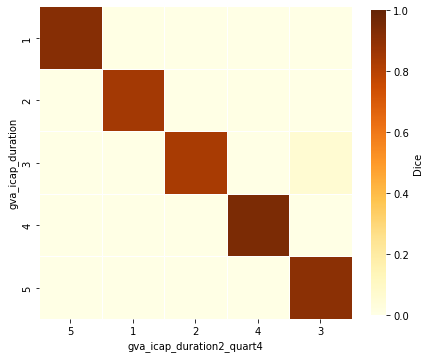

In [5]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=["quart1","quart2","quart3","quart4"]

params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"icap_duration",'t_range':['15min'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=5,t_range1='15min',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

**Comparing splits among them**

t1=quart1 and t2=quart2
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart1/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart2/K_5/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.7426420106752762  ±  0.14
t1=quart1 and t2=quart3
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart1/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart3/K_5/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.8881657127119625  ±  0.04
t1=quart1 and t2=quart4
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart1/K_5/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/icap_duration/quart4/K_5/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.807456736913697  ±  0.08
t1=quart2 and t2=quart3
/media/miplab-nas2/Data3/BMPD/hc_pr

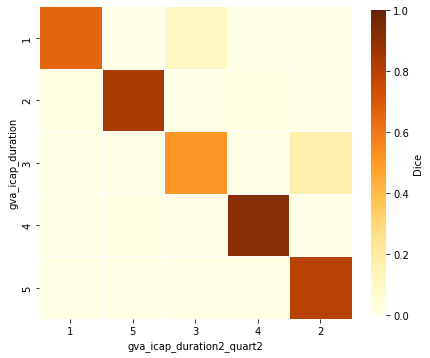

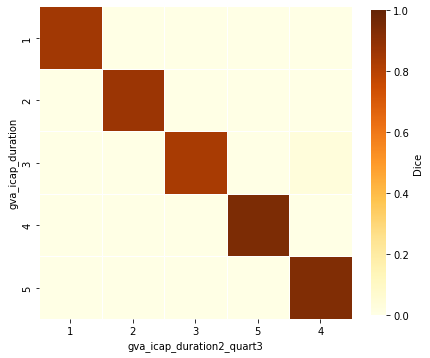

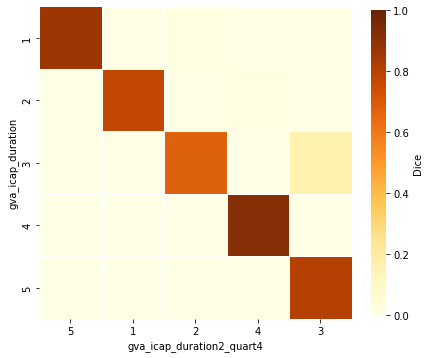

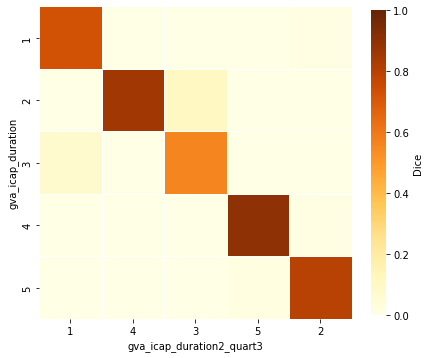

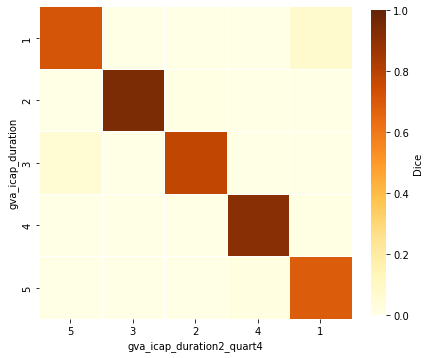

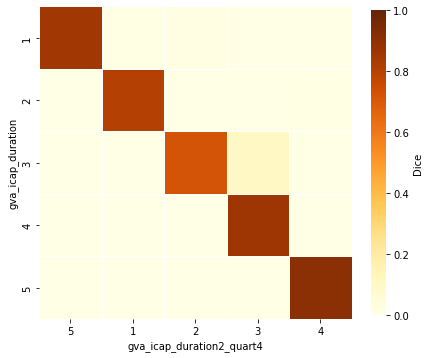

In [8]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=["quart1","quart2","quart3","quart4"]

for t1_ind,t1 in enumerate(t_range):
    for t2_ind,t2 in enumerate(t_range):
        if t2_ind > t1_ind:
            print(f"t1={t1} and t2={t2}")
            params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"icap_duration",'t_range':[t1],'lthresh':1.6}
            params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"icap_duration", 't_range': [t2],'lthresh':1.6}

            spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
            spine_analysis_split_gva.spatial_similarity(k1=5,t_range1=t1,t_range2=[t2],similarity_method='Dice',save_figure=True,verbose=False)

### `ICA` method

**Comparing splits with entire run**

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/all/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/1min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/2min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/3min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/4min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/5min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/6min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/9min/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/12min/K_5/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.12313883878528895  ±  0.06
0.1254408018473048  ±  0

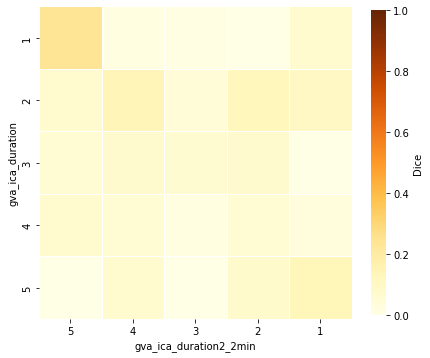

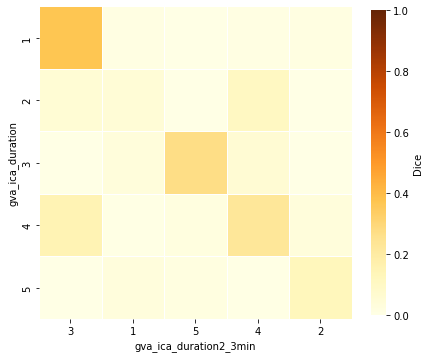

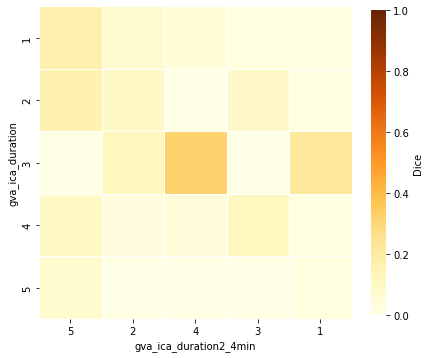

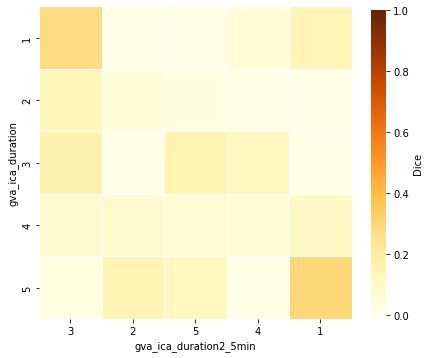

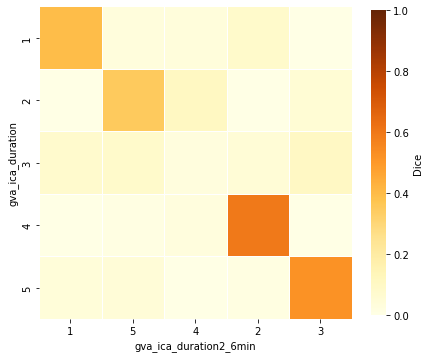

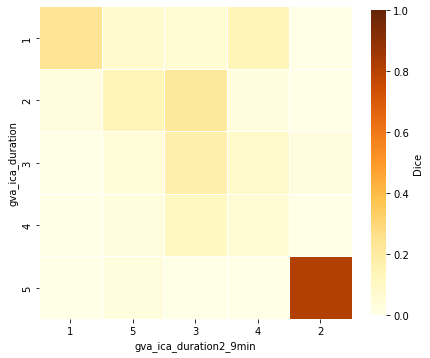

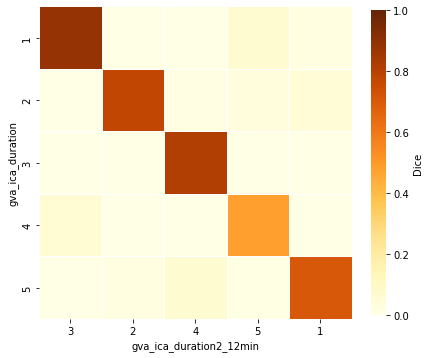

In [15]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
#t_range=["quart1","quart2","quart3","quart4"]
t_range=["1min","2min","3min","4min","5min","6min","9min","12min"]



params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"ica_duration",'t_range':['all'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"ica_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=5,t_range1='all',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

**Comparing splits among them**

t1=quart1 and t2=quart2
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart1/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart2/K_5/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.19926584793776483  ±  0.11
t1=quart1 and t2=quart3
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart1/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart3/K_5/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.2524945410558926  ±  0.18
t1=quart1 and t2=quart4
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart1/K_5/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/gva/ica_duration/quart4/K_5/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.11760674788657673  ±  0.1
t1=quart2 and t2=quart3
/media/miplab-nas2/Data3/BMPD/hc_project//spi

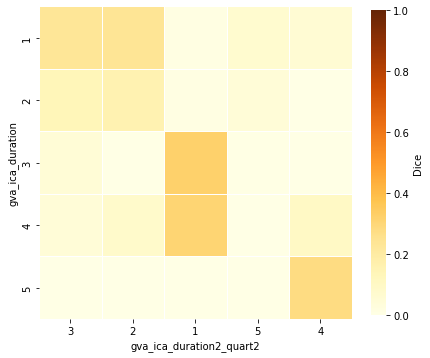

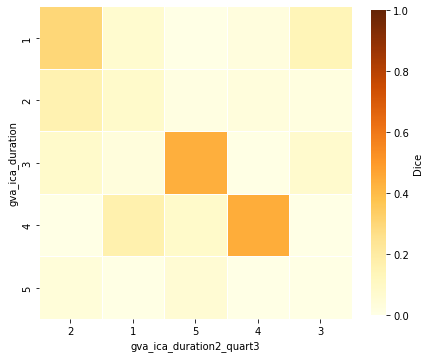

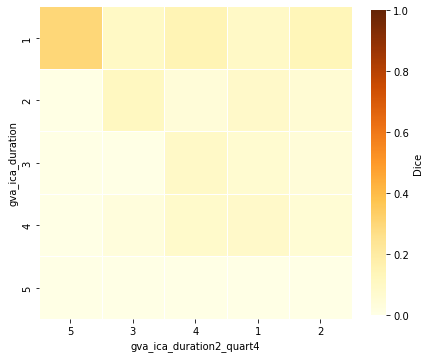

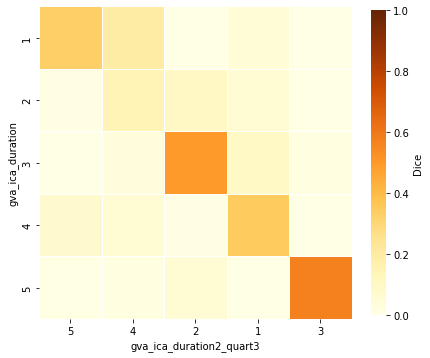

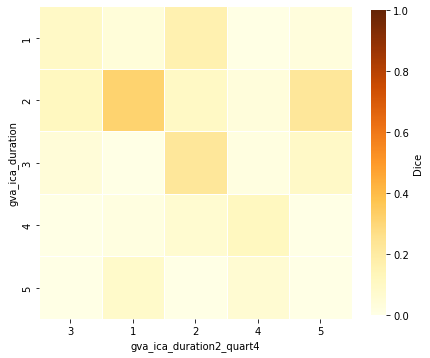

In [9]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=["quart1","quart2","quart3","quart4"]

for t1_ind,t1 in enumerate(t_range):
    for t2_ind,t2 in enumerate(t_range):
        if t2_ind > t1_ind:
            print(f"t1={t1} and t2={t2}")
            params_quant_split_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"ica_duration",'t_range':[t1],'lthresh':1.6}
            params_quant_split_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"ica_duration", 't_range': [t2],'lthresh':1.6}

            spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
            spine_analysis_split_gva.spatial_similarity(k1=5,t_range1=t1,t_range2=[t2],similarity_method='Dice',save_figure=True,verbose=False)

## `MTL` dataset

### Qualitative evaluation

Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)


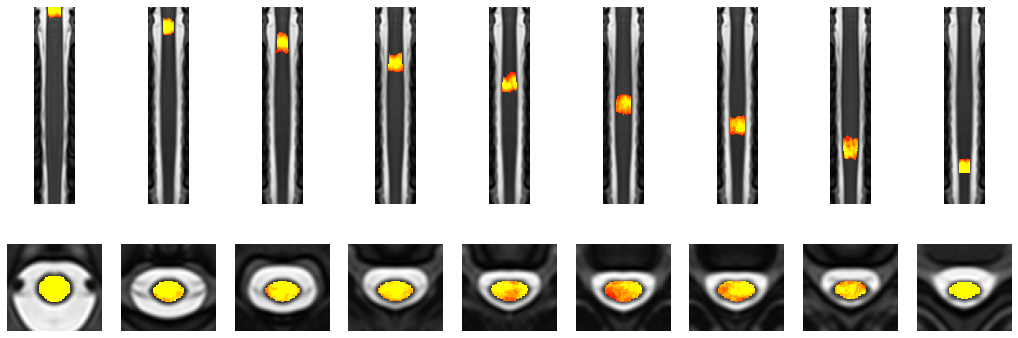

In [81]:
splits = ["half1","half2"]
dataset = 'mtl'

for split in splits:
    params_qual_split_gva = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap_duration', 'duration':split}
    plotting_split_gva = Plotting(config,'spinalcord',params1=params_qual_split_gva)
    plotting_split_gva.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.6, uthresh=3.5, save_results=True, similarity_method='Dice')

### Quantitative evaluation

### `iCAP` method

**Comparing splits with entire run**

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/6min/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/half1/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/half2/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.9324720366827352  ±  0.04
0.9574016747406022  ±  0.02


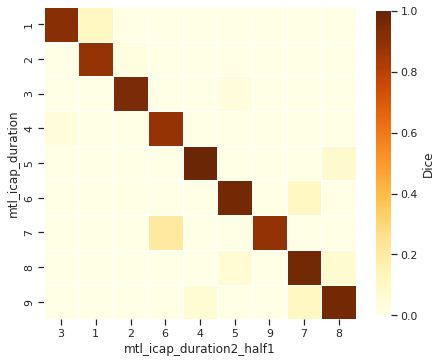

In [307]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset = 'mtl'
t_range=["half1","half2"]

params_quant_split_gva_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':['6min'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=9,t_range1='6min',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

**Comparing splits among them**

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/half1/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/icap_duration/half2/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.8923435852538001  ±  0.05


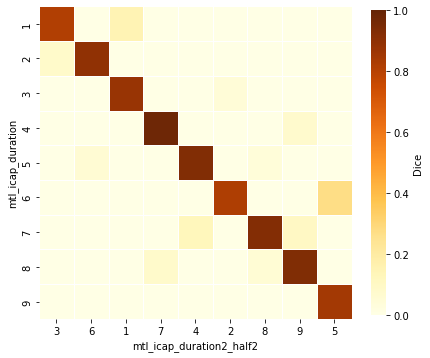

In [4]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset = 'mtl'
t_range=["half1","half2"]

params_quant_split_gva_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':["half1"],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': ["half2"],'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=9,t_range1='half1',t_range2=['half2'],similarity_method='Dice',save_figure=True,verbose=False)

### `ICA` method

**Comparing splits with entire run**

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/ica_duration/all/K_9/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/ica_duration/half1/K_9/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/ica_duration/half2/K_9/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.7204656560703899  ±  0.17
0.685423358396606  ±  0.25


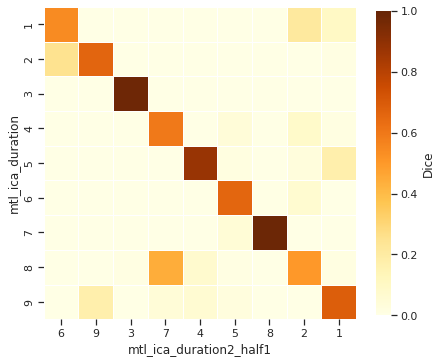

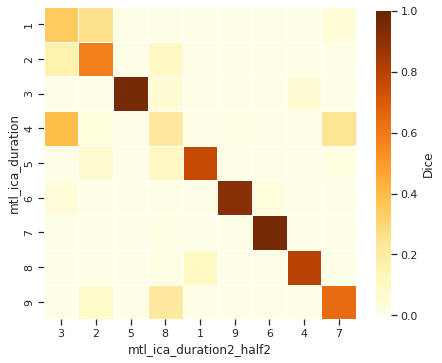

In [174]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset = 'mtl'
t_range=["half1","half2"]

params_quant_split_gva_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"ica_duration",'t_range':['all'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"ica_duration", 't_range': t_range,'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=9,t_range1='all',t_range2=t_range,similarity_method='Dice',save_figure=True,verbose=False)

**Comparing splits among them**

In [12]:
A =  [0.20, 0.25, 0.12, 0.38, 0.22, 0.15];
np.std(A)

0.0834665601703261

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/ica_duration/half1/K_9/comp_zscored/*4D_z*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl/ica_duration/half2/K_9/comp_zscored/*4D_z*
METHOD 3: Comparing sets of components across durations
0.6153582148649449  ±  0.24


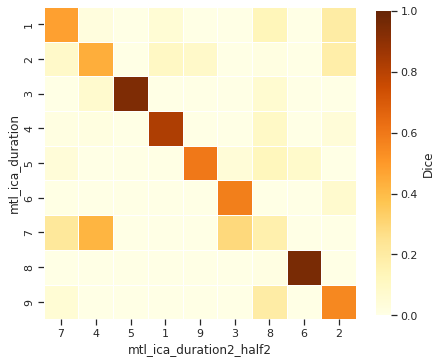

In [304]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset = 'mtl'
t_range=["half1","half2"]
params_quant_split_gva_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"ica_duration",'t_range':['half1'],'lthresh':1.6}
params_quant_split_gva_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"ica_duration", 't_range': ['half2'],'lthresh':1.6}

spine_analysis_split_gva = SpineOnlyAnalysis(config,params1=params_quant_split_gva_1,params2=params_quant_split_gva_2)
spine_analysis_split_gva.spatial_similarity(k1=9,t_range1='half1',t_range2=['half2'],similarity_method='Dice',save_figure=True,verbose=False)

<hr style="border:1px solid black">

# Figure 5 – Subject-specific

## Qualitative evaluation
Here, we just display one example subject for each dataset, displayed on its own mean T2 image

### `GVA` dataset

Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/results/individual_analyses/mtl/Overlap/Indiv_spinalcord_gva_icap_5_14_thr1.6to3.5.png


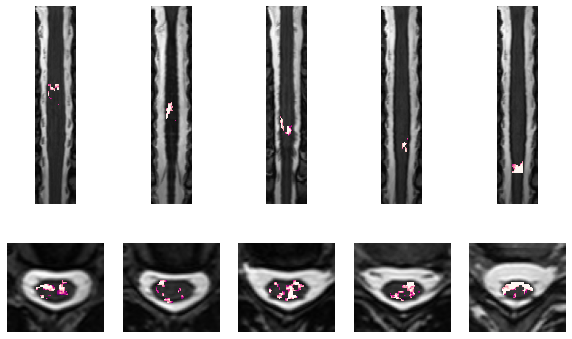

In [56]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis

#sub='01'
for sub in ['14']: #config['list_subjects']['gva']:
    params_qual_1 = {'k':5, 'dataset':'gva', 'analysis':'icap', 'subject':sub,'lthresh':1.6}   

    plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
    #plotting.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, template=config['main_dir']+'spine_only/gva/sub-'+sub+'/sub-'+sub+'_anat2template_resampled.nii.gz', colormap_two=[cmap_group,'RdPu_r'], save_results=True)
    plotting.sc_plot(show_spinal_levels=False, k_per_line=5, lthresh=1.6, uthresh=3.5, template=config['main_dir']+'spine_only/gva/sub-'+sub+'/sub-'+sub+'_anat2template_resampled.nii.gz',colormap_one='RdPu_r', save_results=True,centering_method='max')

### `MTL` dataset

Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (center-of-mass big

/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/plotting.py:202: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, axs = plt.subplots(nrows=total_rows,ncols=k_per_line,figsize=(2*k_per_line, 4*total_rows))


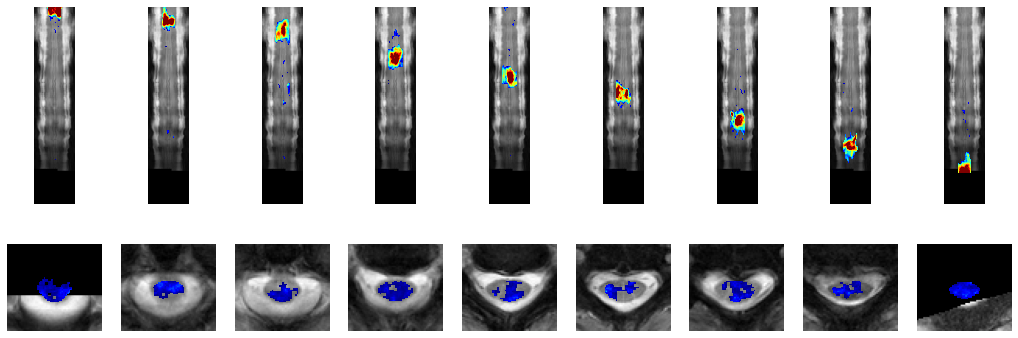

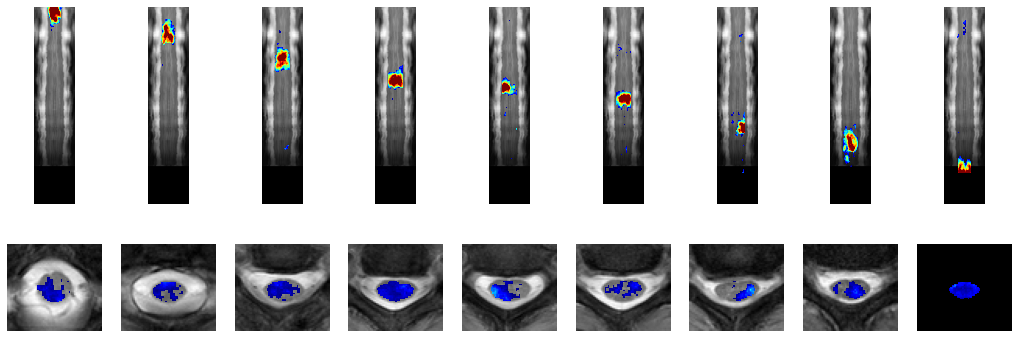

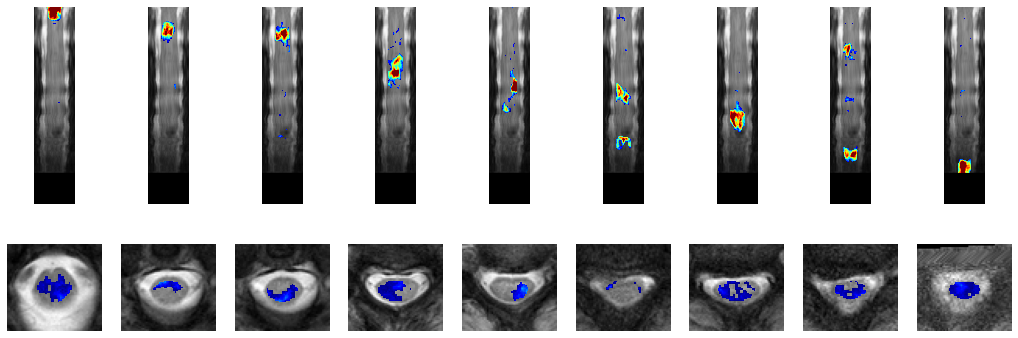

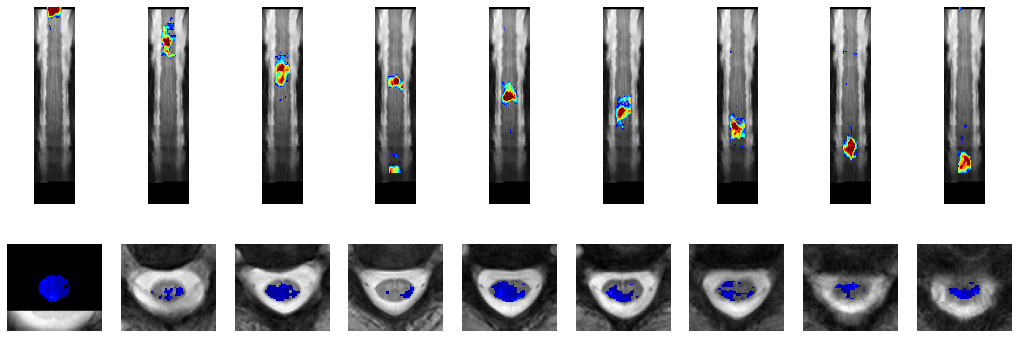

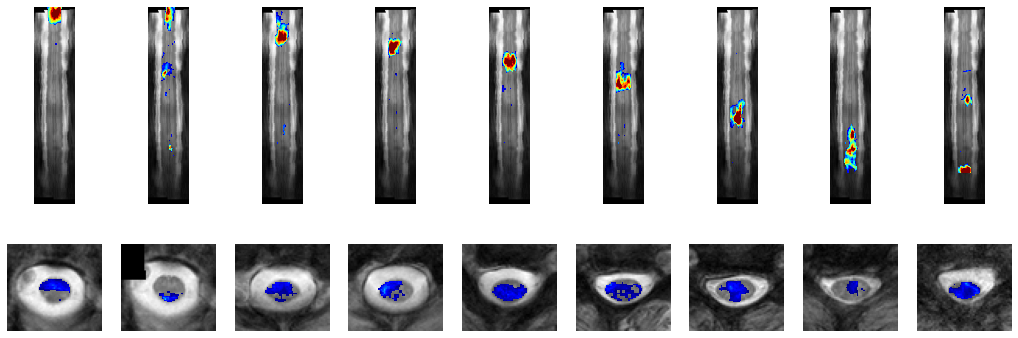

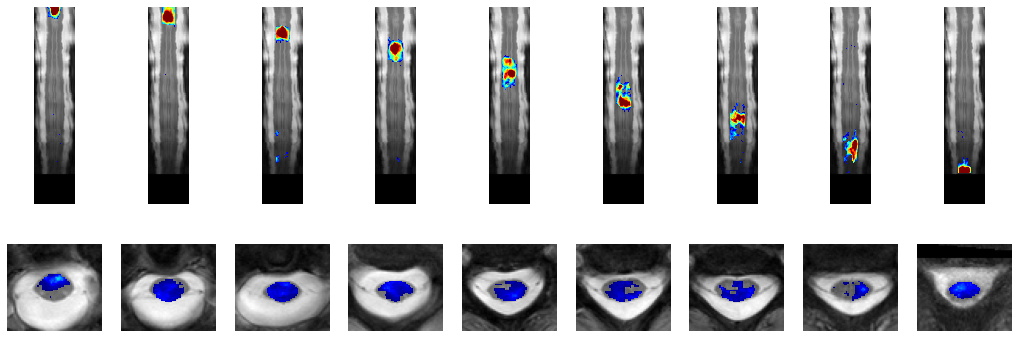

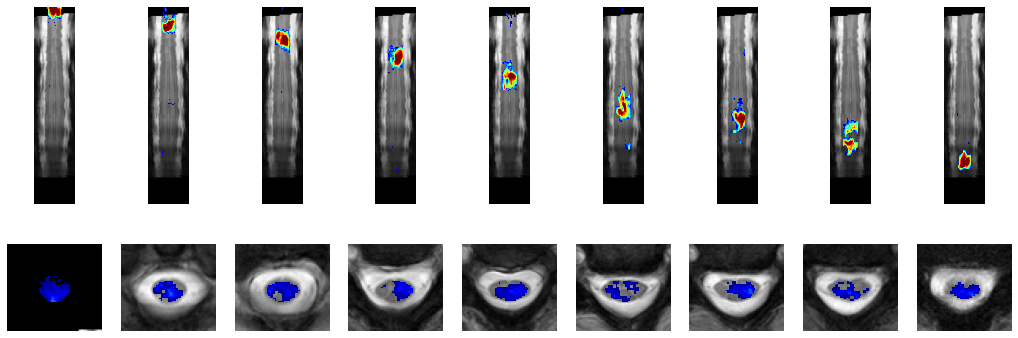

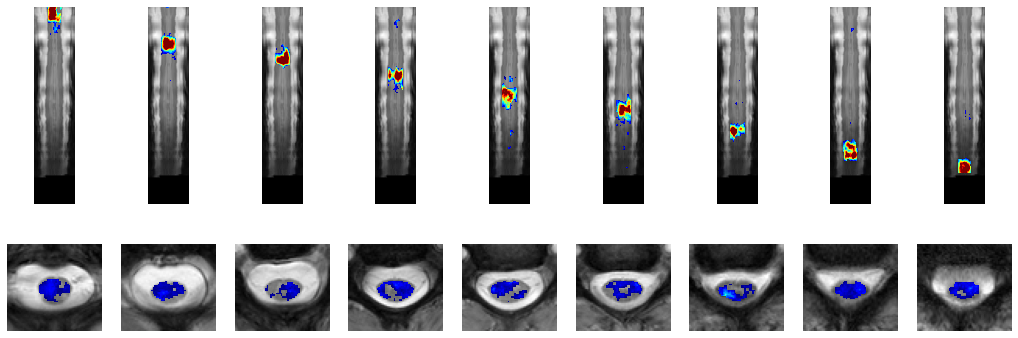

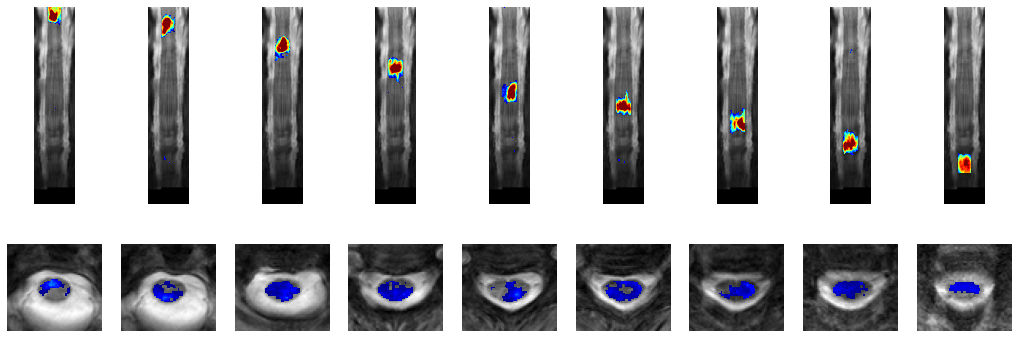

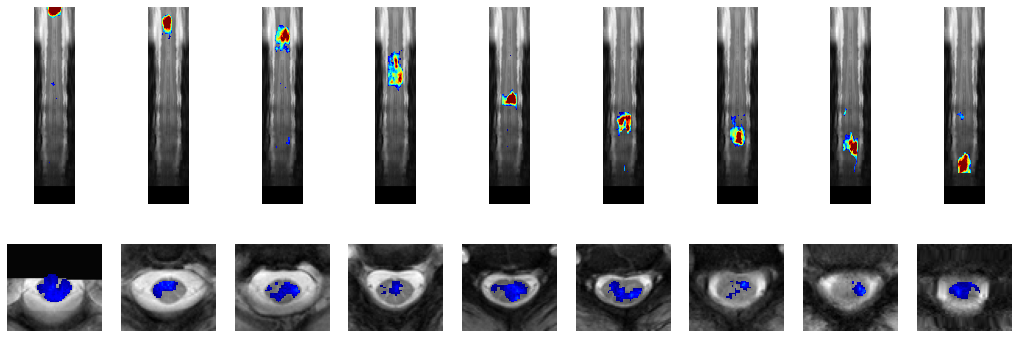

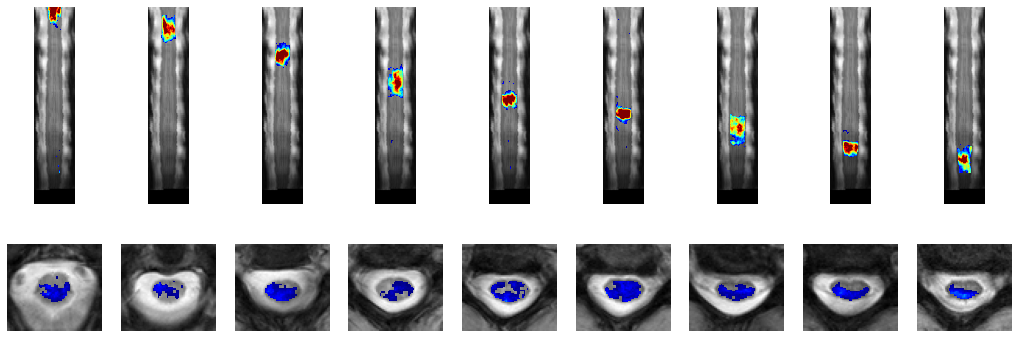

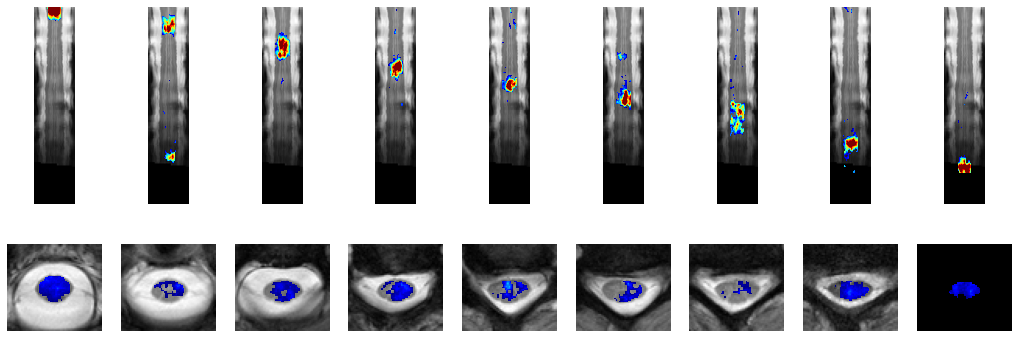

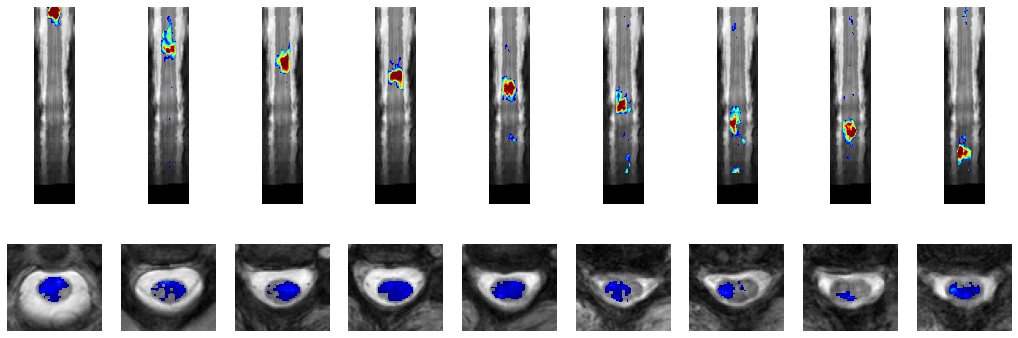

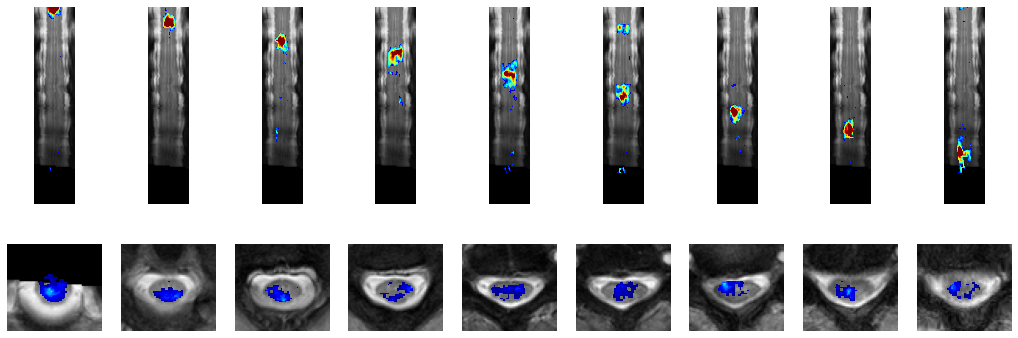

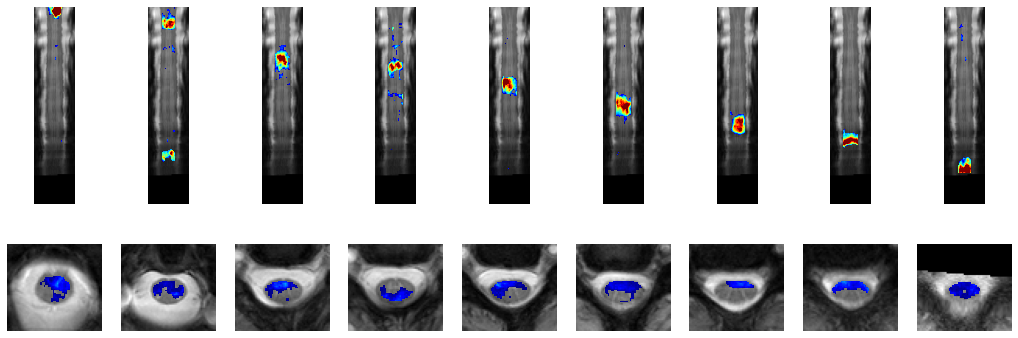

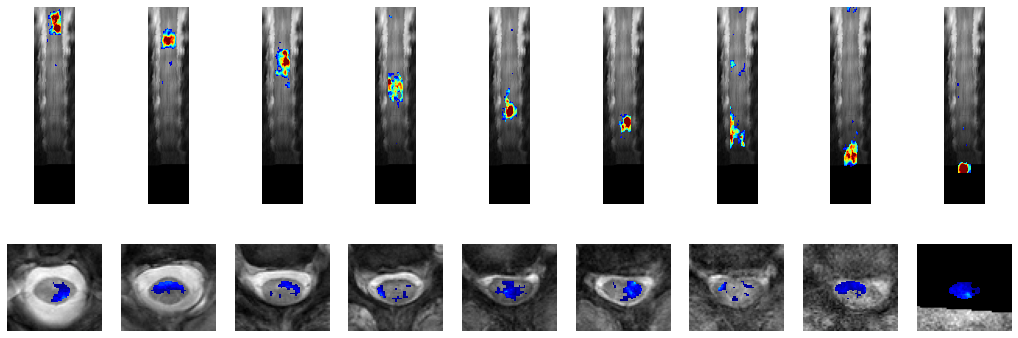

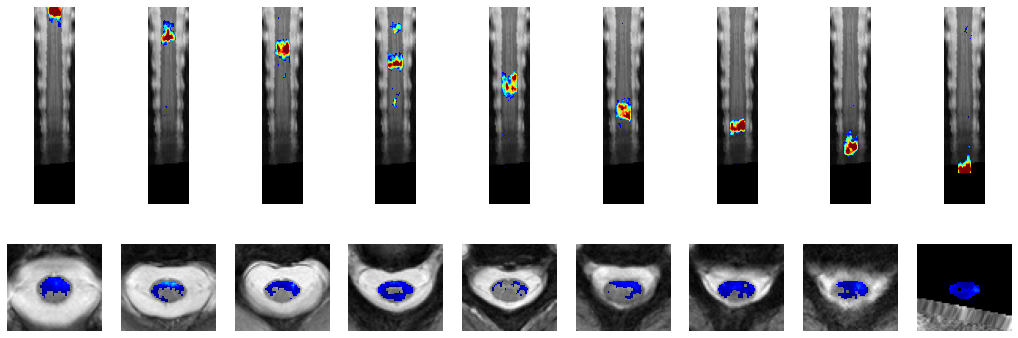

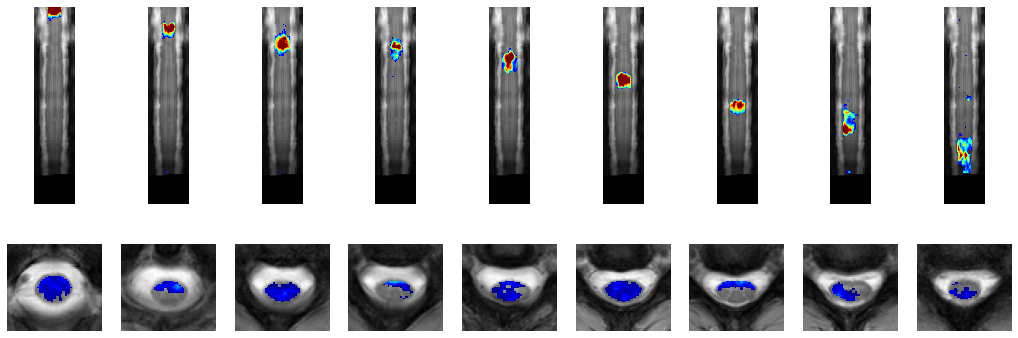

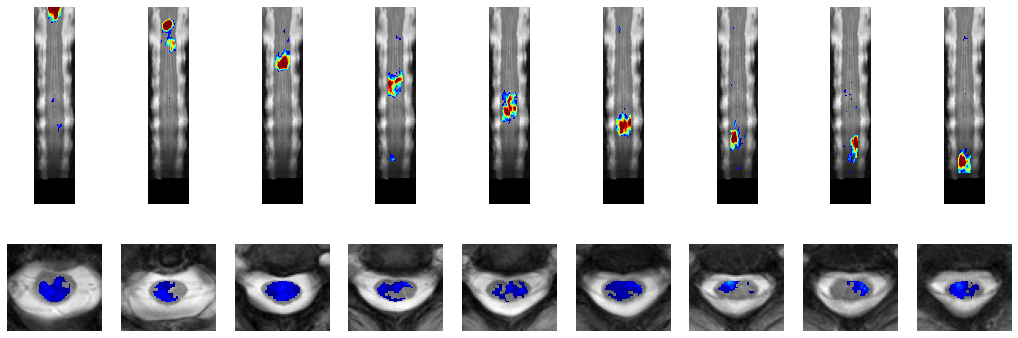

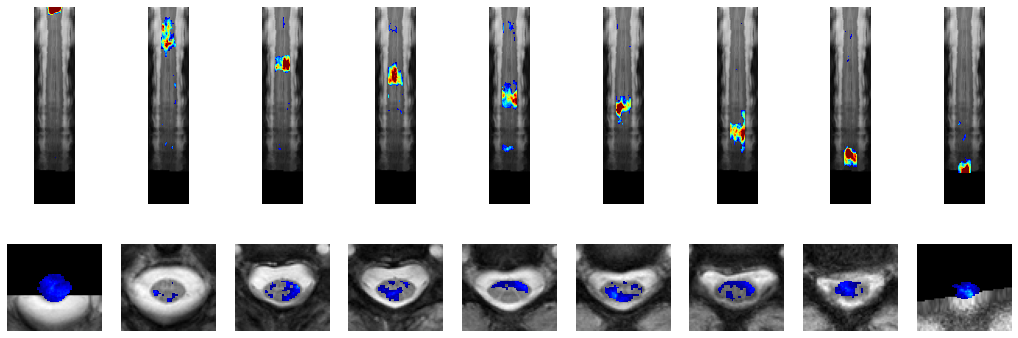

In [44]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis

#sub = 'A011'
for sub in config['list_subjects']['mtl']:
    #params_qual_1 = {'k':9, 'dataset':'mtl', 'analysis':'icap','lthresh':1.6}   
    params_qual_1 = {'k':9, 'dataset':'mtl', 'analysis':'icap', 'subject':sub,'lthresh':1.6}   

    plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
    #plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
    plotting.sc_plot(show_spinal_levels=False, k_per_line=9, plot_mip=True, lthresh=1.6, uthresh=35, template=config['main_dir']+'spine_only/mtl/sub-'+sub+'/sub-'+sub+'_T2w_coreg_in_PAM50_resampled.nii.gz', centering_method='middle',colormap_one='jet', save_results=False)

### Prepare videos

In [123]:
import cv2

redo=True # put True to create an other video
if redo==True:
    dataset="mtl"
    analysis="icap"
    img_array = []
    for filename in sorted(glob.glob(config["main_dir"] + config["output_dir"] + '/video_' + dataset + '*.png')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(config["main_dir"] + config["output_dir"]  +'Indiv_spinalcord_'+dataset+'_' + analysis + '_movie.avi',cv2.VideoWriter_fourcc(*'MJPG'), 2, size)


    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

## Heatmap of the distribution

Sorting method: no_sorting
The plotting will be displayed in neurological orientation (Left > Right)


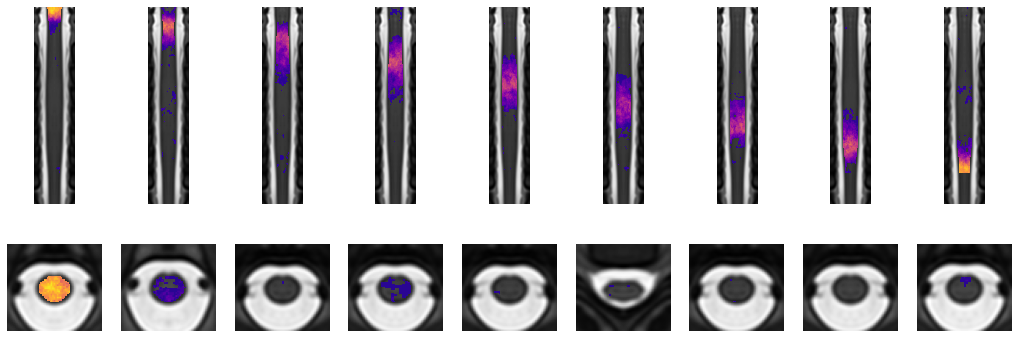

In [29]:
redo_distribution_map=True
if redo_distribution_map==True:
    for dataset in ["mtl"]:
        for ana in ["icap"]:
            params_heat_1 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)),'dataset':dataset, 'analysis':ana,'lthresh':1.6}   
            spine_analysis = SpineOnlyAnalysis(config,params1=params_heat_1,params2=params_heat_1,load_subjects=True)
            spine_analysis.subject_distribution(spine_analysis.name1, k=params_heat_1['k_range'][0])
            
save_plots=True
for dataset in ["mtl"]:
    for ana in ["icap"]:
        config["output_tag"]= "Distribution"
        config["data"][dataset][ana]["spinalcord"]["tag_filename"]=".nii.gz"
        params_qual_1 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':ana, 'subject':"distribution"}
        plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=None,sorting_method='no_sorting')
        plotting.sc_plot(show_spinal_levels=False, k_per_line=params_qual_1['k'], lthresh=0, uthresh=len(config["list_subjects"][dataset]), save_results=save_plots,centering_method='middle',colormap_one='plasma')

with open('../../config/config_spine_only_NK.json') as config_file:
    config = json.load(config_file)

In [9]:
dataframe={};dataframe_comp={}
extract=True # put extract=True to extract the values
lthresh=1.6
compare_atlas= True

for dataset in ["mtl","gva"]:
    dataframe[dataset]={};dataframe_comp[dataset]={}
    if compare_atlas==True:
        print("Individual value are going to be compared to the atlas components")
        dataset1="atlas"
        lthresh=1
    else:
        print("Individual value are going to be compared to the group analysis components")
        dataset1=dataset
        lthresh=1.6
        
    for ana in ["ica","icap"]:
        dataframe[dataset][ana]={};dataframe_comp[dataset][ana]={}
        if compare_atlas==True:
            ana1="icap"
        else:
            ana1=ana
        
        for measure in ["Overlap"]:
            #config["output_dir"]= "/spine_only/results/individual_analyses/" + dataset + "/"+measure+"/"
            config["output_tag"]= "Indiv"
            
            if extract == True:
                # the first parameter should be the reference (e.g. group or atlas components, individual component will not be load)
                params_quant_1 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)),'dataset':dataset1, 'analysis':ana1, 'lthresh':lthresh}

                #for sub in config['list_subjects'][dataset]:
                #params_quant_2 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)), 'dataset':dataset, 'analysis':"icap", 'subject':'sub-'+sub, 'lthresh':1.6}
                params_quant_2 = {'k_range':(range(9,10) if dataset == 'mtl' else range(5,6)), 'dataset':dataset, 'analysis':ana, 'lthresh':1.6}

                spine_analysis = SpineOnlyAnalysis(config,params1=params_quant_1,params2=params_quant_2,load_subjects=True)
                spine_analysis.spatial_similarity(k1=params_quant_2["k_range"][0],k2=params_quant_2["k_range"][0],similarity_method=measure,save_results=True,save_figure=False)

            input_comp= glob.glob(config["main_dir"] +config["output_dir"] + config["output_tag"] + "*"+ dataset1 + "*" +ana1 +"*vs_"+dataset+"*" +ana+ "*indiv_comp.txt")[0]
            input_file= glob.glob(config["main_dir"] +config["output_dir"] + config["output_tag"] + "*" + dataset1+"*" +ana1 +"*vs_"+dataset+"*"  +ana+ "*indiv.txt")[0]
            
            dataframe_comp[dataset][ana][measure]=pd.read_csv(input_comp, header=0,sep=' ')
            dataframe[dataset][ana][measure]=pd.read_csv(input_file, header=0,sep=' ')
            
frames=[dataframe["mtl"]["ica"][measure],dataframe["gva"]["ica"][measure],dataframe["mtl"]["icap"][measure],dataframe["gva"]["icap"][measure]]; 
frames=pd.concat(frames)
frames_comp=[dataframe_comp["mtl"]["ica"][measure],dataframe_comp["gva"]["ica"][measure],dataframe_comp["mtl"]["icap"][measure],dataframe_comp["gva"]["icap"][measure]] ; 
frames_comp=pd.concat(frames_comp)
frames.to_csv(config['main_dir'] + config['output_dir'] + 'dice_indiv_' + config['output_tag'] + '.csv', sep=' ', index=False)

Individual value are going to be compared to the atlas components
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//Atlas_Frostell//K_9/comp_zscored/*.nii.gz
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/mtl/spinalcord//K_9/comp_zscored/*4D_z
Subject loading for mtl_ica...
METHOD 1: Comparing two sets of components at specific K values 
atlas_icap at K = 9 vs mtl_ica at K = 9 

Sorting method: rostrocaudal (max value)
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//Atlas_Frostell//K_9/comp_zscored/*.nii.gz
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_spine_only/mtl/spinalcord//K_9/comp_zscored/*_z.nii
Subject loading for mtl_icap...
METHOD 1: Comparing two sets of components at specific K values 
atlas_icap at K = 9 vs mtl_icap at K = 9 

Sorting method: rostrocaudal (max value)
Individual value are going to be compared to the atlas components
/cerebro/cerebro1/dataset

In [8]:
dataframe

{'gva': {'ica': {'Overlap':    subj_name dataset analysis   Overlap
   0     sub-01     gva      ica  0.451050
   1     sub-02     gva      ica  0.530350
   2     sub-03     gva      ica  0.441024
   3     sub-04     gva      ica  0.419888
   4     sub-05     gva      ica  0.503797
   5     sub-06     gva      ica  0.497818
   6     sub-07     gva      ica  0.381849
   7     sub-08     gva      ica  0.515031
   8     sub-09     gva      ica  0.468645
   9     sub-10     gva      ica  0.675612
   10    sub-12     gva      ica  0.559442
   11    sub-11     gva      ica  0.458934
   12    sub-13     gva      ica  0.592404
   13    sub-14     gva      ica  0.435752
   14    sub-15     gva      ica  0.641074
   15    sub-16     gva      ica  0.676208
   16    sub-17     gva      ica  0.638707
   17    sub-18     gva      ica  0.485693
   18    sub-19     gva      ica  0.445916},
  'icap': {'Overlap':    subj_name dataset analysis   Overlap
   0     sub-01     gva     icap  0.827874
   1    

In [5]:
frames[frames['dataset'] == 'gva']

NameError: name 'frames' is not defined

In [37]:
for dataset in ["mtl","gva"]:
     for ana in ["ica","icap"]:
            mean_overlap = round(frames[(frames['dataset'] == dataset) & (frames['analysis'] == ana)].mean()*100,2).values[0]
            std_overlap = round(frames[(frames['dataset'] == dataset) & (frames['analysis'] == ana)].std()*100,2).values[0]

            print(f"{dataset}-{ana} = {mean_overlap}+-{std_overlap}")

mtl-ica = 50.33+-6.68
mtl-icap = 68.1+-6.02


/tmp/ipykernel_3343783/3414613322.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_overlap = round(frames[(frames['dataset'] == dataset) & (frames['analysis'] == ana)].mean()*100,2).values[0]
/tmp/ipykernel_3343783/3414613322.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_overlap = round(frames[(frames['dataset'] == dataset) & (frames['analysis'] == ana)].std()*100,2).values[0]


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/results/Indiv_Overlap_individuals.pdf


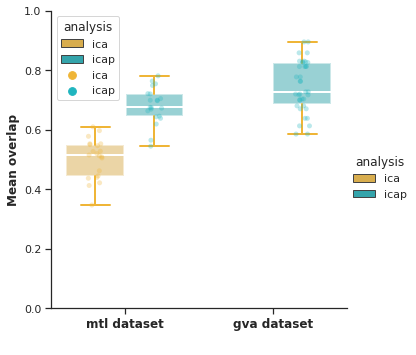

In [30]:
#frames=[dataframe["mtl"]["ica"]["Dice"],dataframe["gva"]["ica"]["Dice"]]; frames=pd.concat(frames)

import seaborn as sns
colors=['#efb537','#20b5bf'] #'#273248'
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="Overlap",x="dataset",data=frames, kind="box", hue="analysis", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
                boxprops=dict(alpha=.5,edgecolor=None),whiskerprops=dict(color=colors[0]), capprops=dict(color=colors[0]), fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(6,5)

sns.stripplot(x="dataset", y="Overlap",data=frames, hue="analysis",
             size=5,palette=colors, alpha=.3, linewidth=0, edgecolor='white',dodge=True)

g.set(ylim=(0, 1))
g.set_axis_labels(" ", "Mean overlap",fontsize=12, fontweight='bold')
g.set_xticklabels(["mtl dataset","gva dataset"],weight='bold',fontsize=12);
print(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_Overlap_individuals.pdf')
g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_Overlap_individuals.pdf', format='pdf')



<hr style="border:1px solid black">

# Figure X – Re-test

## Qualitative evaluation

Sorting method: rostrocaudal (center-of-mass biggest cluster)
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


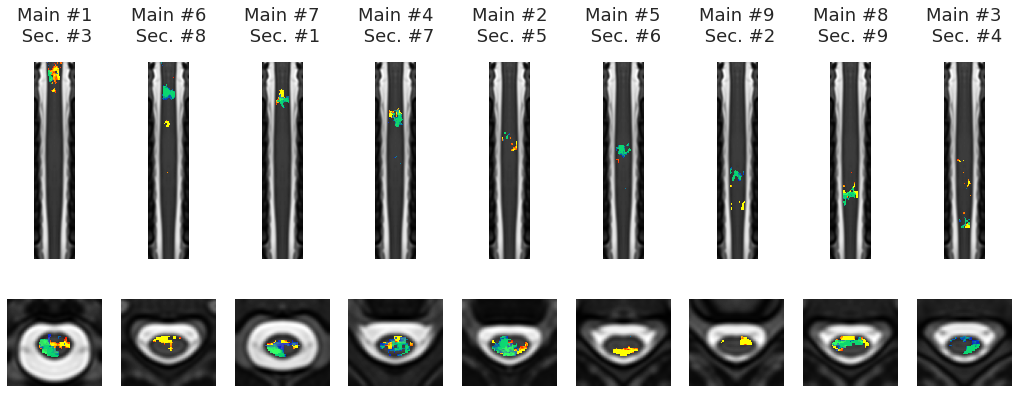

In [62]:
splits = ["S07-run-01","S07-run-02"]
dataset = 'mtl_retest'
params_qual_retest_1 = {'k':9, 'dataset':dataset, 'analysis':'icap_duration', 'duration':splits[0],'lthresh':1.6}
params_qual_retest_2 = {'k':9, 'dataset':dataset, 'analysis':'icap_duration', 'duration':splits[1],'lthresh':1.6}

plotting_retest = Plotting(config,'spinalcord',params1=params_qual_retest_1,params2=params_qual_retest_2, sorting_method='rostrocaudal_CoM')
plotting_retest.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=1.6, uthresh=3.5, save_results=False, centering_method="middle", similarity_method='Dice')

Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neurological orientation (Left > Right)
Sorting method: rostrocaudal (max value)
The plotting will be displayed in neuro

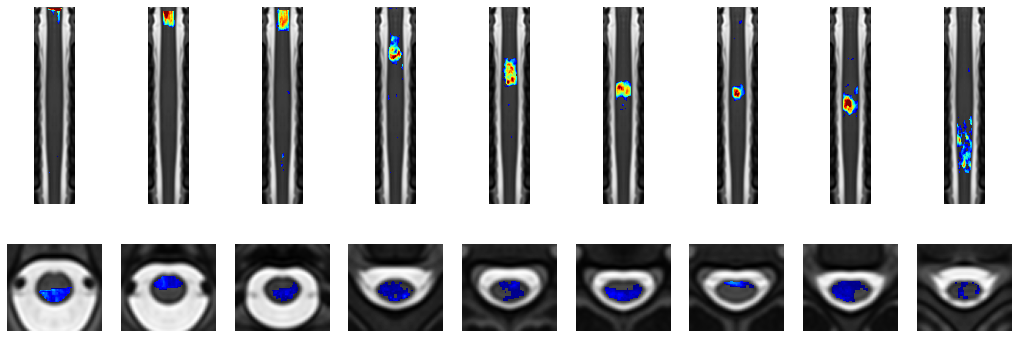

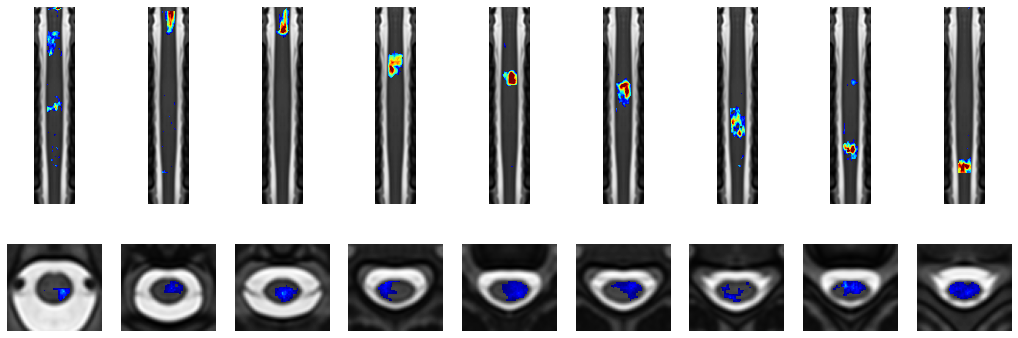

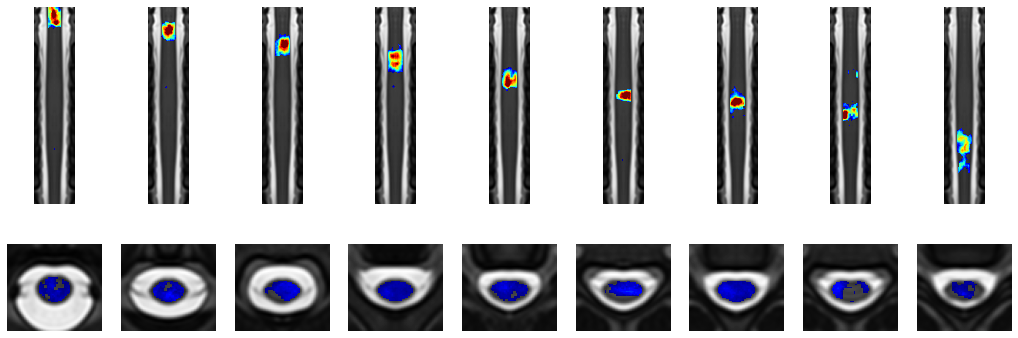

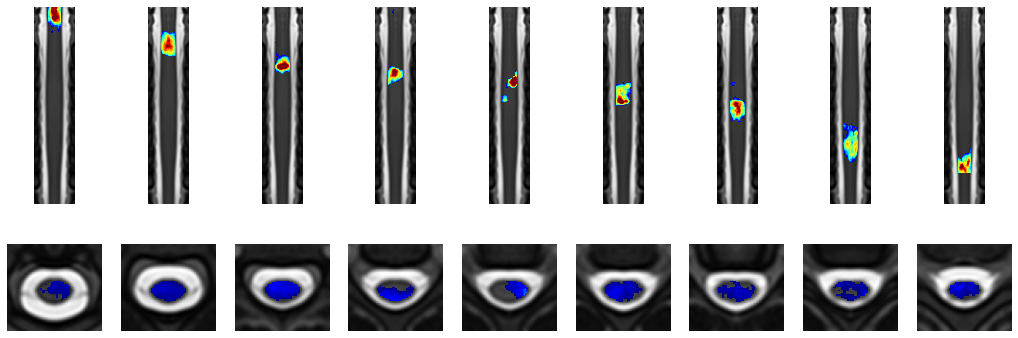

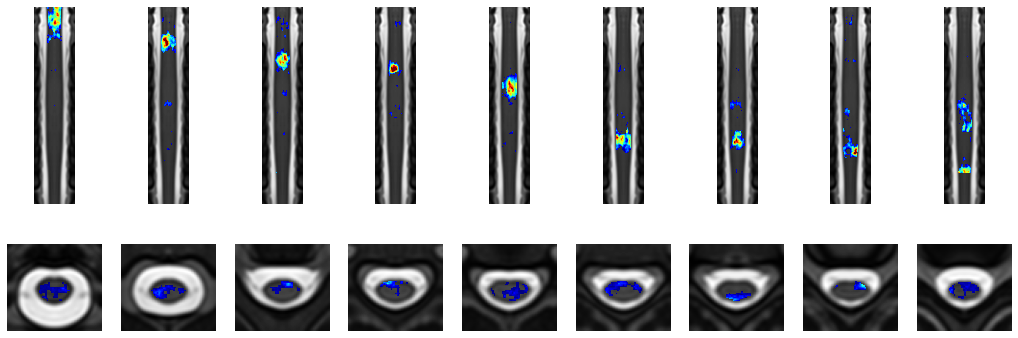

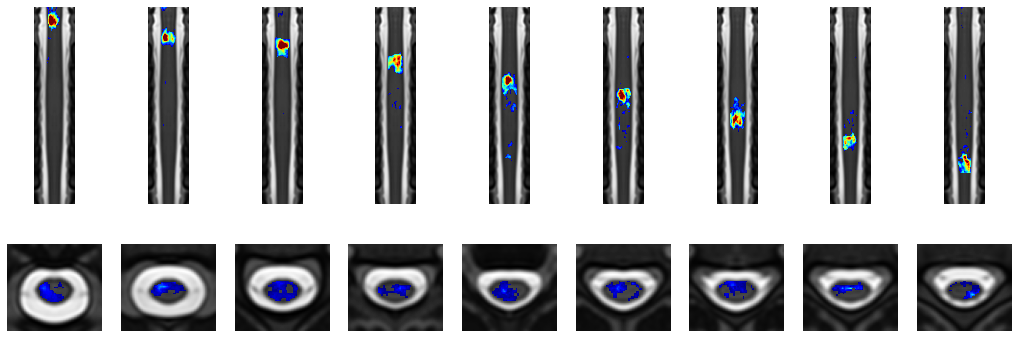

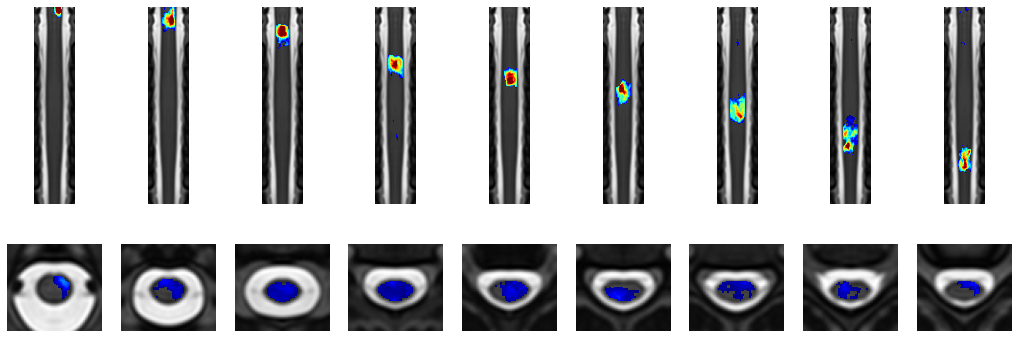

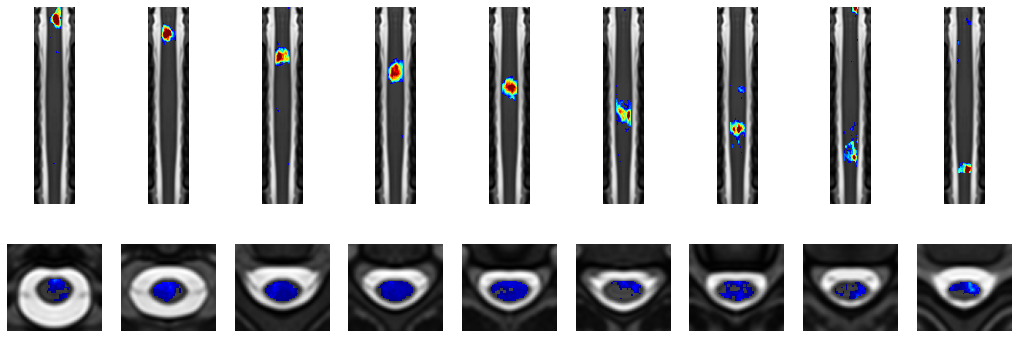

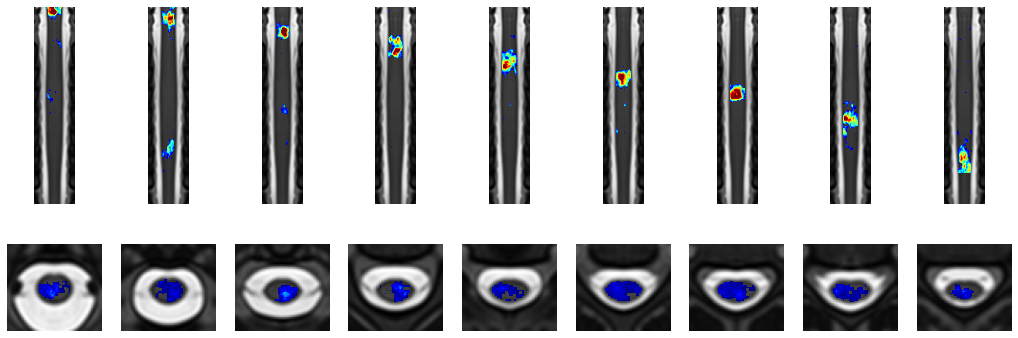

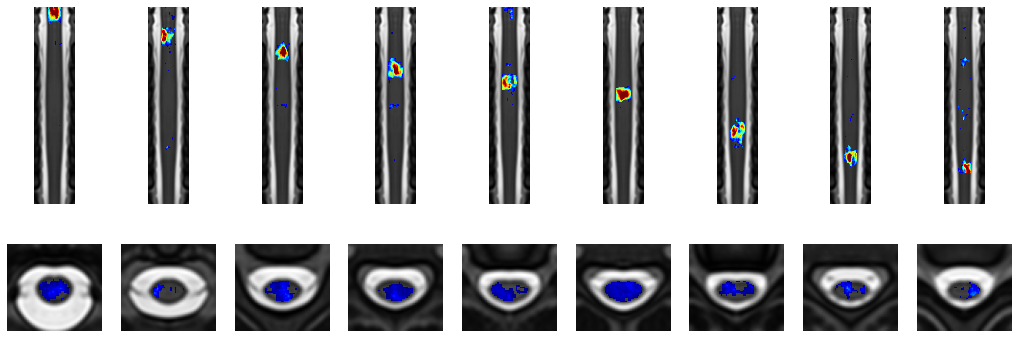

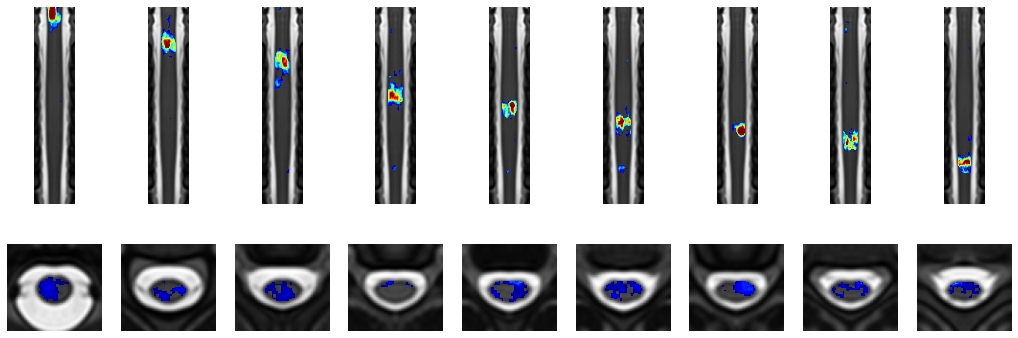

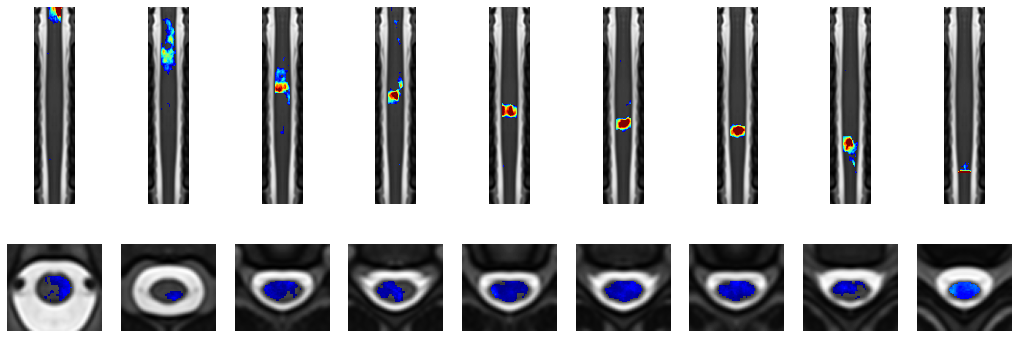

In [63]:
all_splits = ["S02-run-01","S02-run-02","S03-run-01","S03-run-02","S07-run-01","S07-run-02","S09-run-01","S09-run-02","S10-run-01","S10-run-02","S14-run-01","S14-run-02"]
dataset = 'mtl_retest'
for split in all_splits:
    params_qual_retest_1 = {'k':9, 'dataset':dataset, 'analysis':'icap_duration', 'duration':split,'lthresh':1.6}
    #params_qual_retest_2 = {'k':9, 'dataset':dataset, 'analysis':'icap_duration', 'duration':splits[1]}

    plotting_retest = Plotting(config,'spinalcord',params1=params_qual_retest_1)
    plotting_retest.sc_plot(show_spinal_levels=False, k_per_line=9, plot_mip=True, lthresh=1.6, uthresh=45, colormap_one='jet', save_results=True, centering_method="middle", similarity_method='Dice')

## Quantitative evaluation

In [10]:
[split for split in all_splits if split.startswith(subject)]


['S14-run-01', 'S14-run-02']

In [13]:
dataset = 'mtl_retest'
all_splits = ["S02-run-01","S02-run-02","S03-run-01","S03-run-02","S07-run-01","S07-run-02","S09-run-01","S09-run-02","S10-run-01","S10-run-02","S14-run-01","S14-run-02"]

subjects = sorted(set(split.split('-')[0] for split in all_splits))

within = np.zeros(len(subjects),1)
between = np.zeros(len(subjects),len(subjects)-1)

for subject in subjects:    
    subject_runs = [split for split in all_splits if split.startswith(subject)]
    
    # Compare runs within the subject
    run_1 = subject_runs[0]
    run_2 = subject_runs[1]
    
    params_quant_retest_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':run_1,'lthresh':1.6}
    params_quant_retest_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': run_2,'lthresh':1.6}

    spine_analysis_retest = SpineOnlyAnalysis(config,params1=params_quant_retest_1,params2=params_quant_retest_2)
    spine_analysis_retest.spatial_similarity(k1=9,t_range1=t_range[0],t_range2=[t_range[1]],similarity_method='Dice',save_figure=False,verbose=False)
    
    # Compare runs across other subjects
    other_subjects = sorted(set(split.split('-')[0] for split in all_splits) - {subject})

    # Compare with runs from other subjects
    for other_subject in other_subjects:
        other_subject_runs = [split for split in all_splits if split.startswith(other_subject)]
        for run_2 in other_subject_runs:
            

Comparing S02-run-01 with S02-run-02
Comparing S02-run-01 with S03-run-01
Comparing S02-run-01 with S03-run-02
Comparing S02-run-01 with S07-run-01
Comparing S02-run-01 with S07-run-02
Comparing S02-run-01 with S09-run-01
Comparing S02-run-01 with S09-run-02
Comparing S02-run-01 with S10-run-01
Comparing S02-run-01 with S10-run-02
Comparing S02-run-01 with S14-run-01
Comparing S02-run-01 with S14-run-02
Comparing S03-run-01 with S03-run-02
Comparing S03-run-01 with S02-run-01
Comparing S03-run-01 with S02-run-02
Comparing S03-run-01 with S07-run-01
Comparing S03-run-01 with S07-run-02
Comparing S03-run-01 with S09-run-01
Comparing S03-run-01 with S09-run-02
Comparing S03-run-01 with S10-run-01
Comparing S03-run-01 with S10-run-02
Comparing S03-run-01 with S14-run-01
Comparing S03-run-01 with S14-run-02
Comparing S07-run-01 with S07-run-02
Comparing S07-run-01 with S02-run-01
Comparing S07-run-01 with S02-run-02
Comparing S07-run-01 with S03-run-01
Comparing S07-run-01 with S03-run-02
C

/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-01/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-02/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.3311305834295999  ±  0.2
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-01/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S03-run-01/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.35480503258504714  ±  0.2
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-01/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S03-run-02/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.3492825693200783  ±  0.22
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-01/K_9/

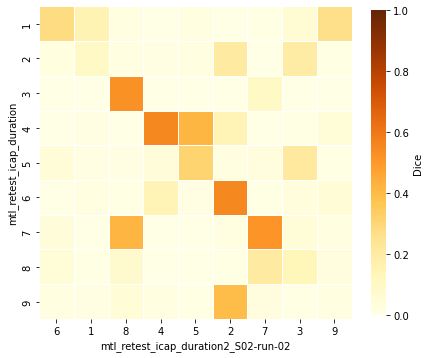

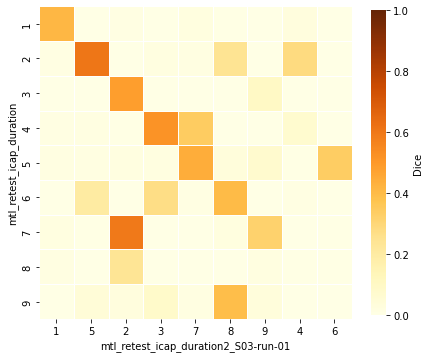

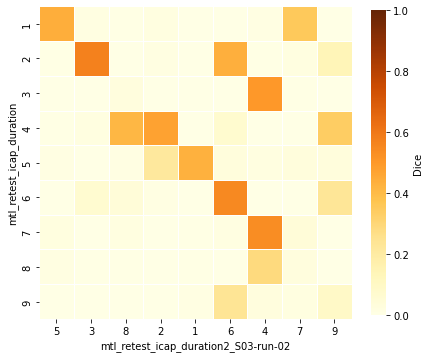

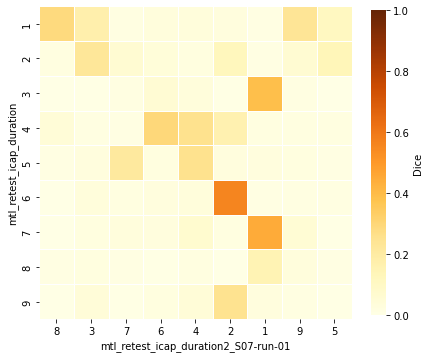

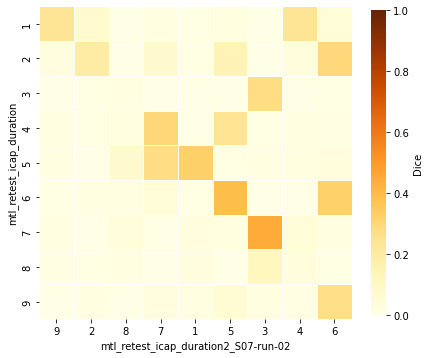

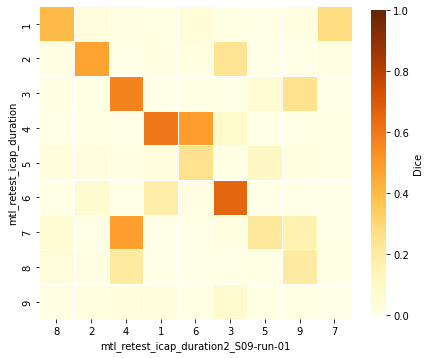

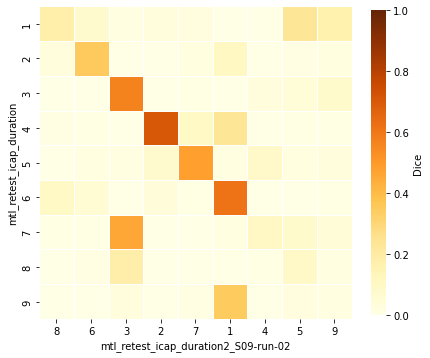

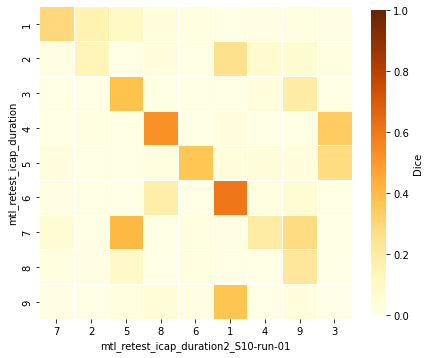

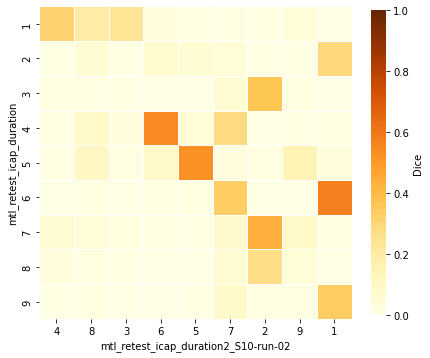

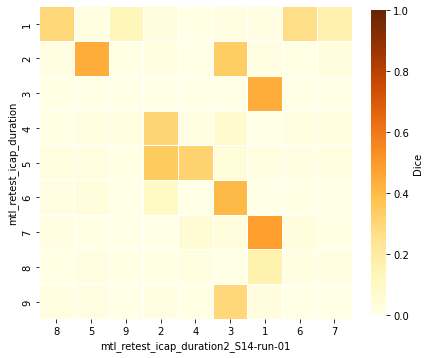

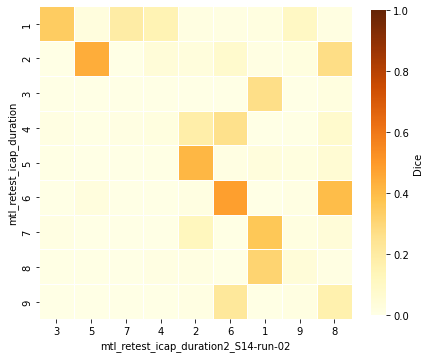

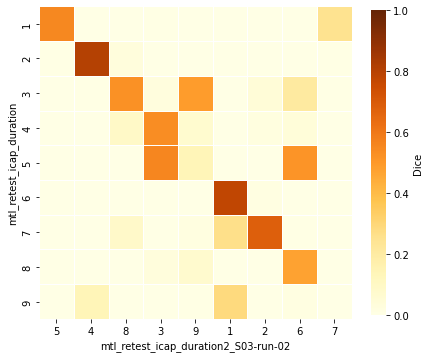

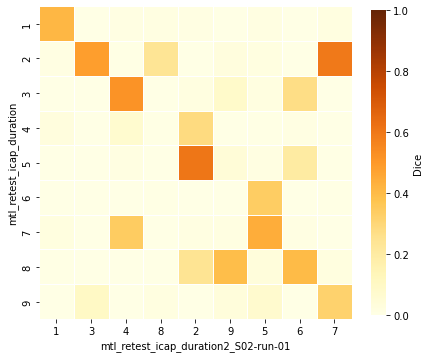

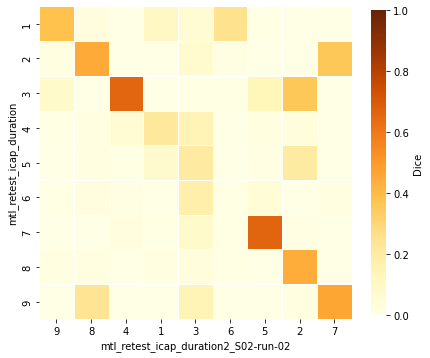

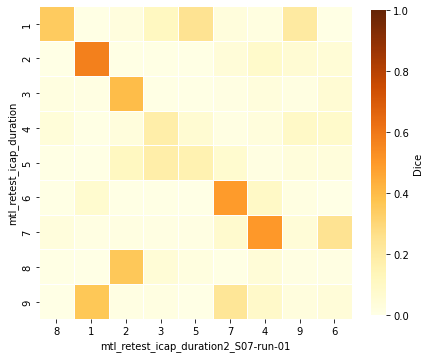

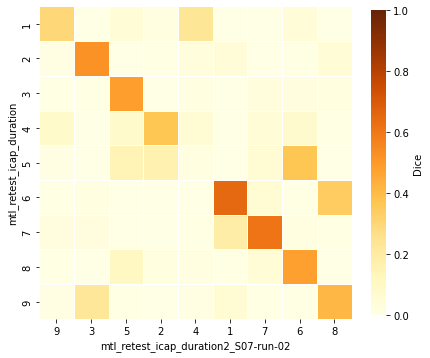

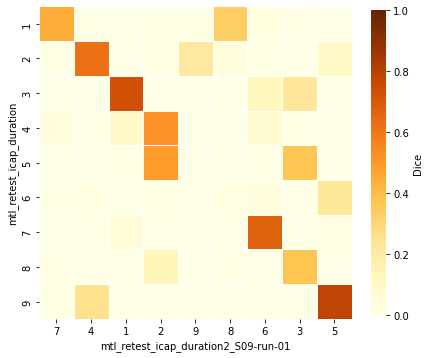

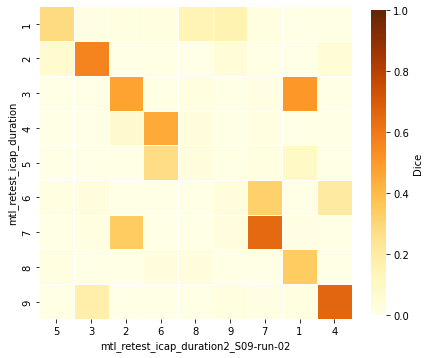

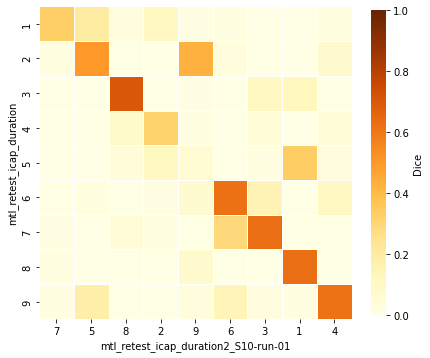

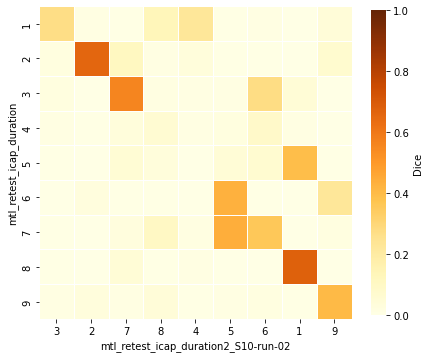

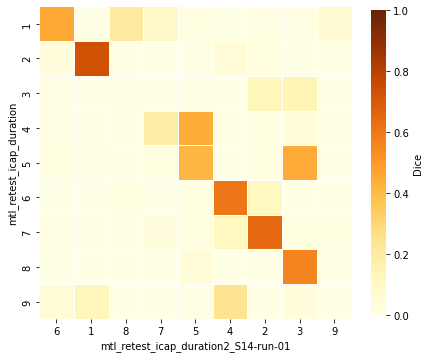

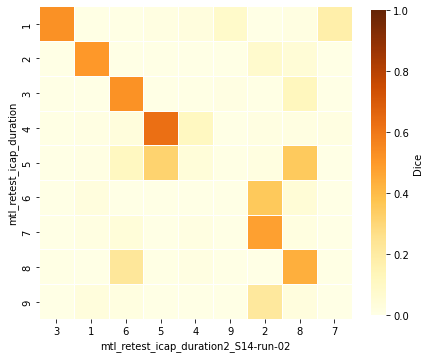

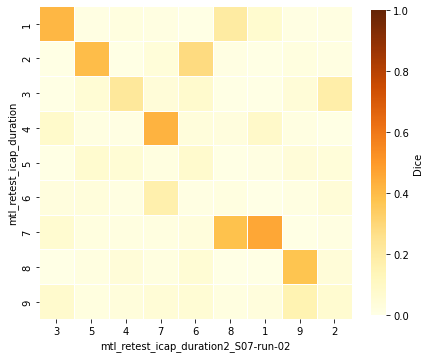

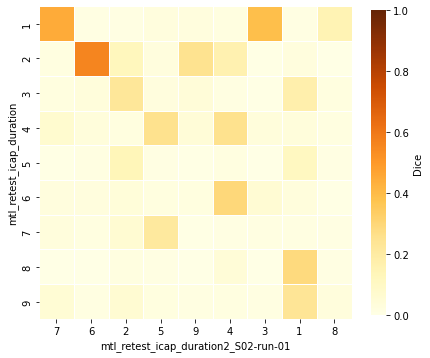

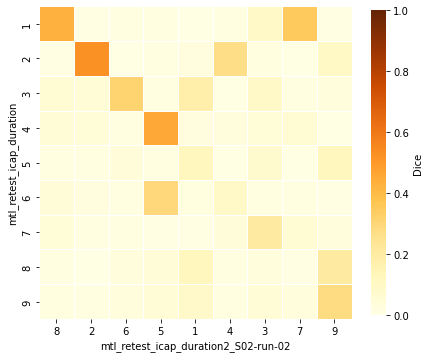

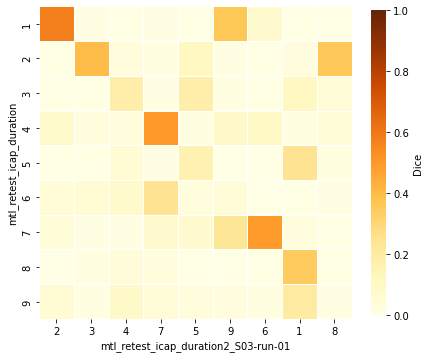

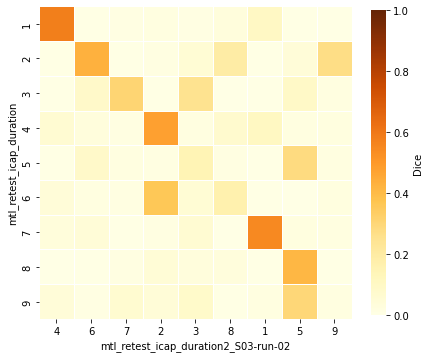

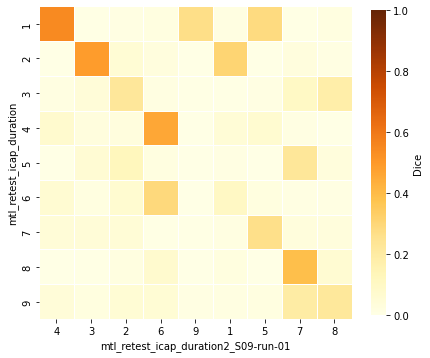

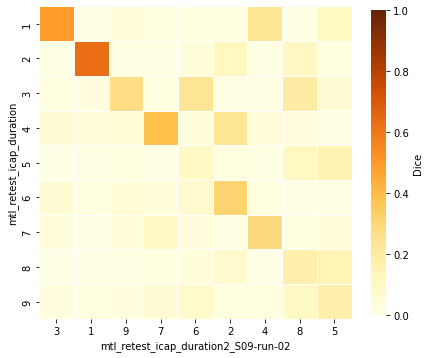

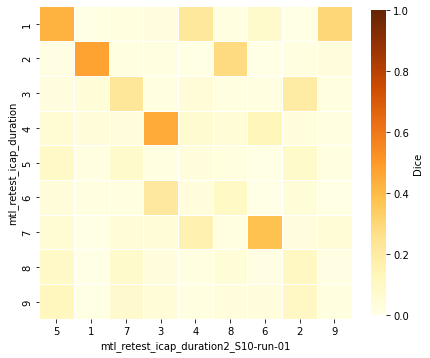

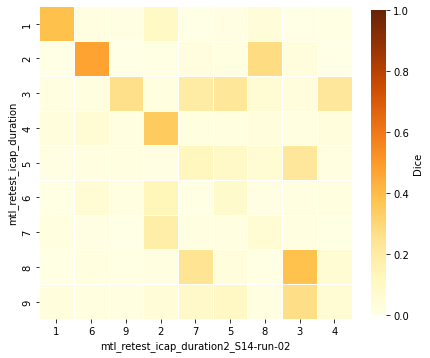

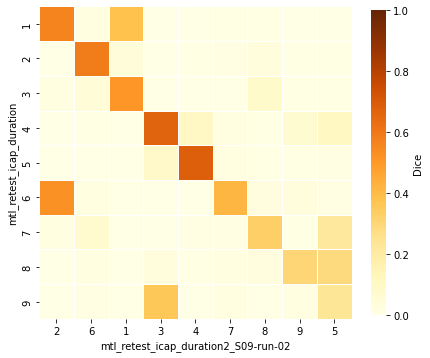

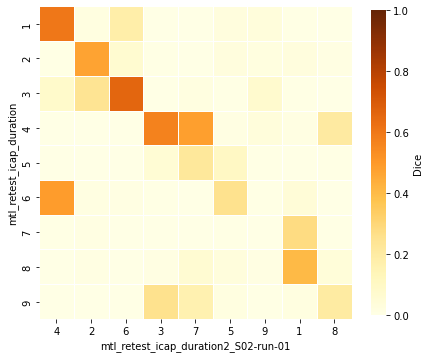

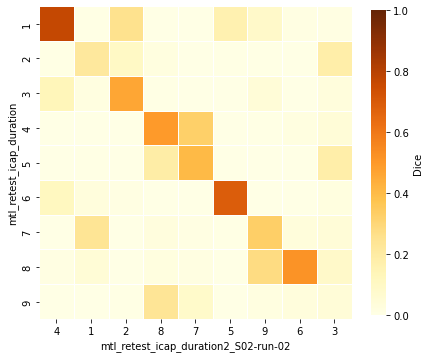

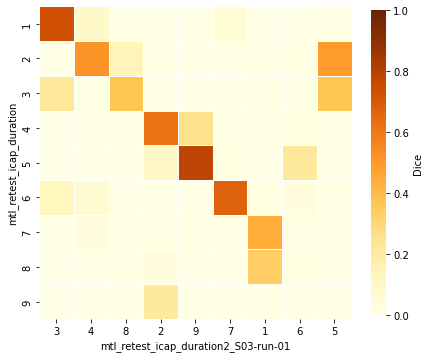

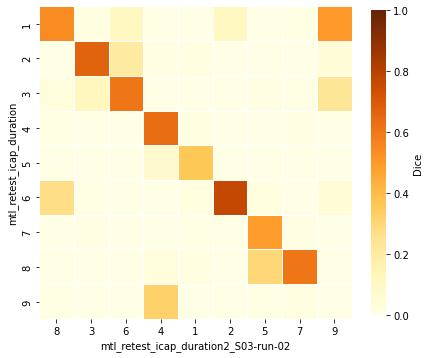

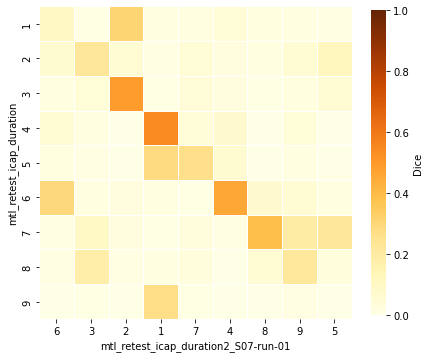

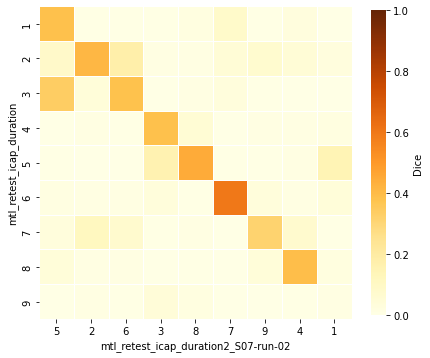

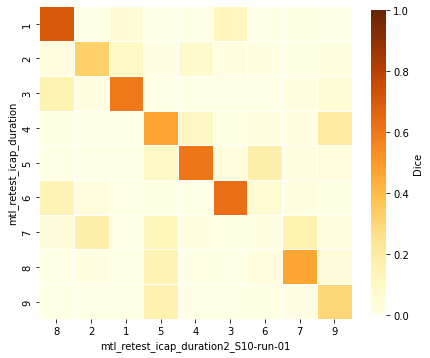

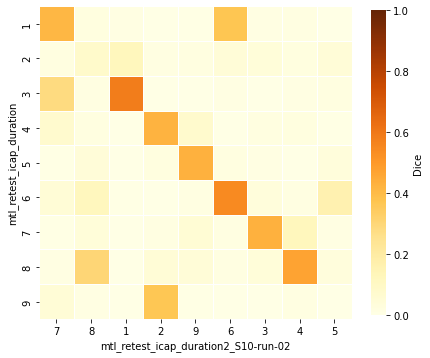

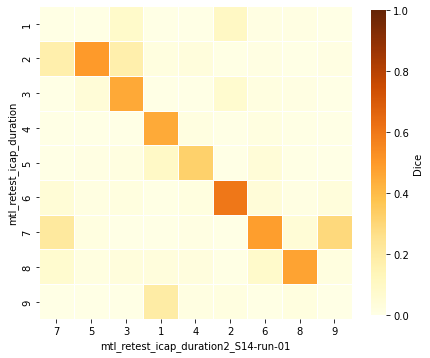

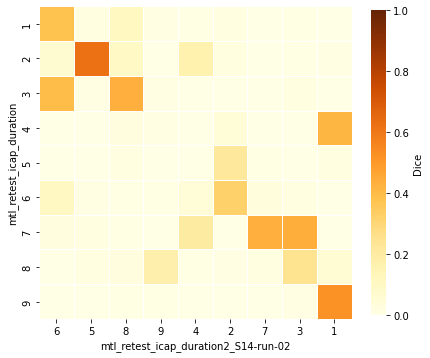

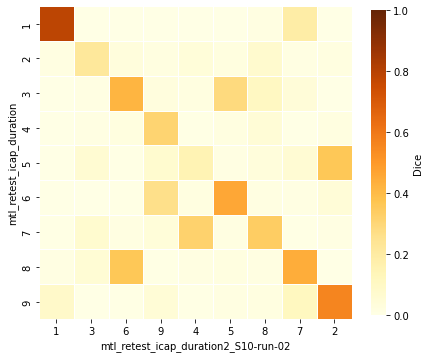

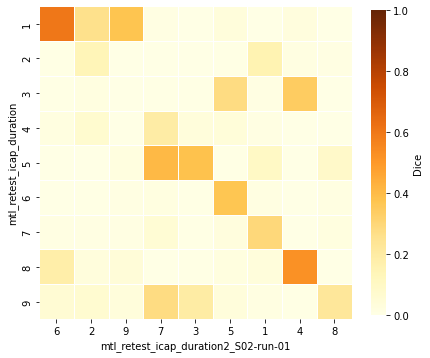

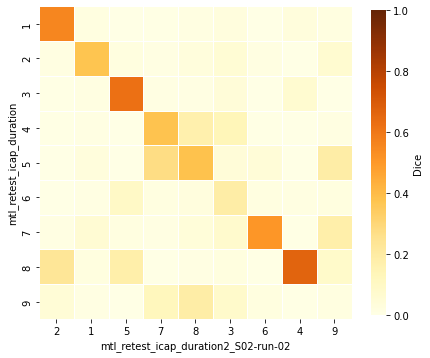

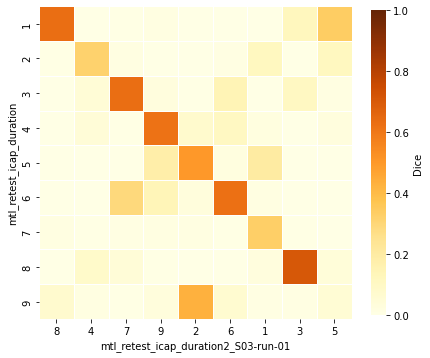

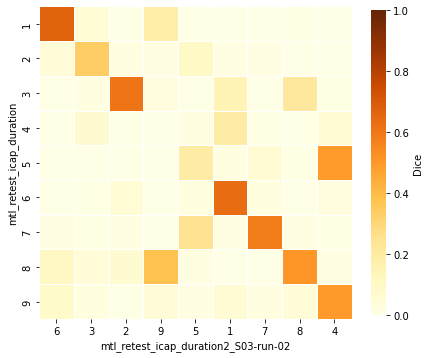

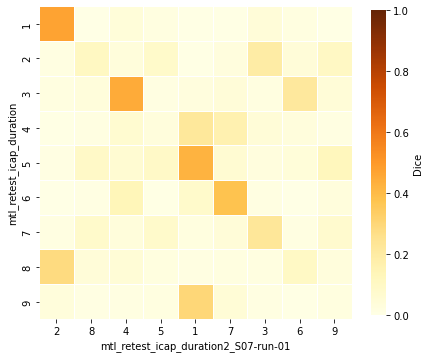

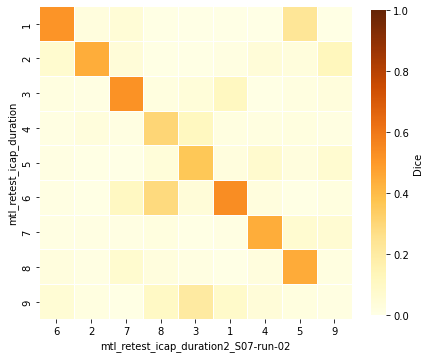

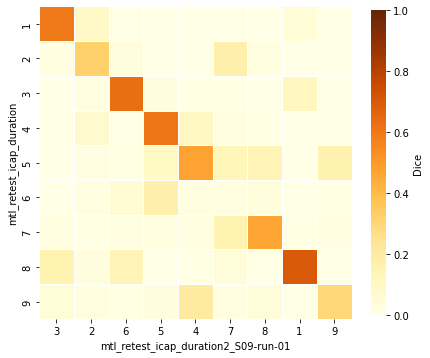

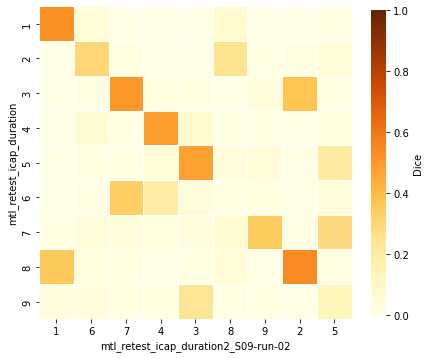

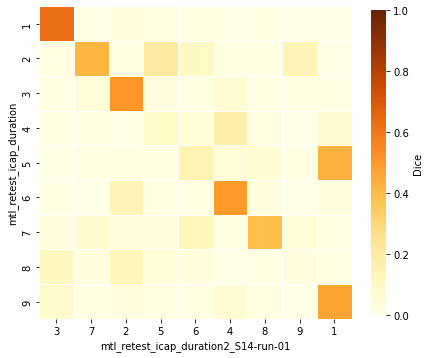

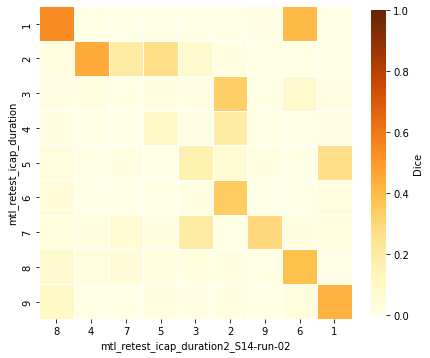

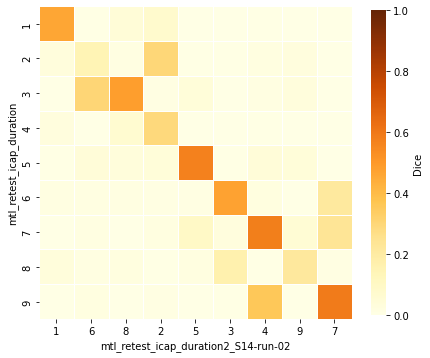

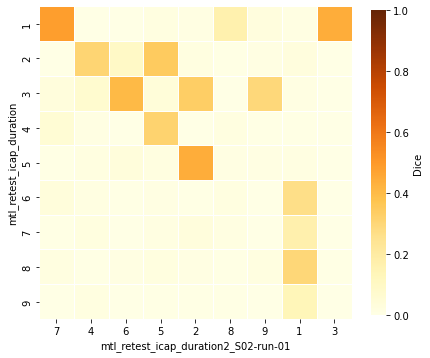

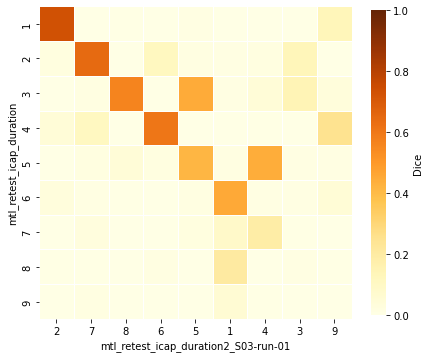

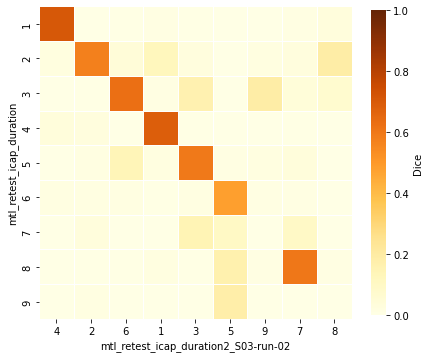

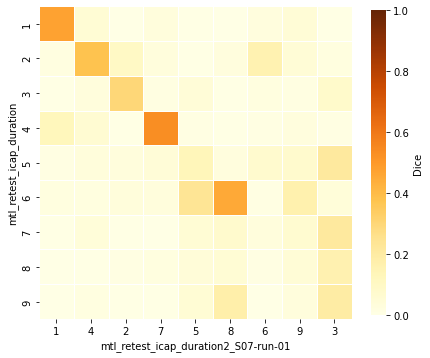

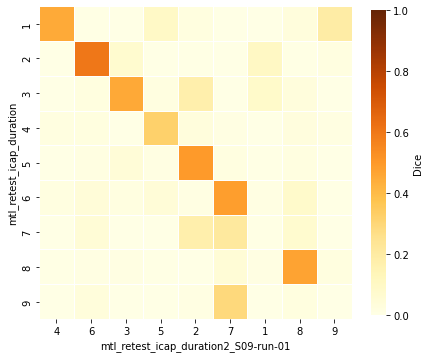

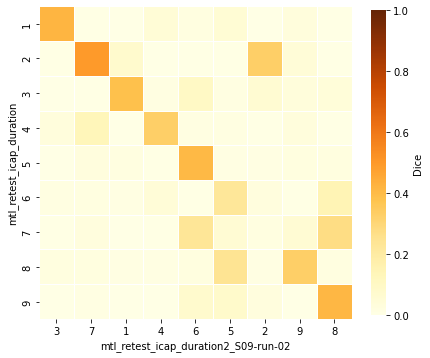

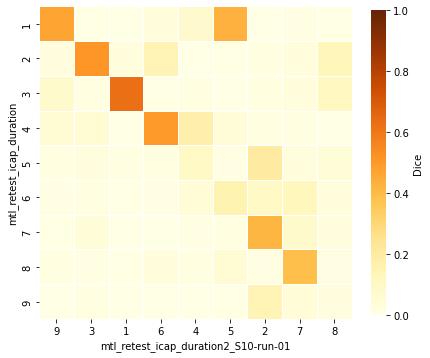

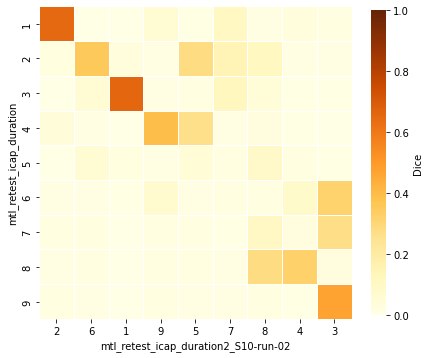

In [53]:
dataset = 'mtl_retest'
all_splits = ["S02-run-01","S02-run-02","S03-run-01","S03-run-02","S07-run-01","S07-run-02","S09-run-01","S09-run-02","S10-run-01","S10-run-02","S14-run-01","S14-run-02"]

subjects = sorted(set(split.split('-')[0] for split in all_splits))

within = np.zeros((len(subjects),1))
between = np.zeros((len(subjects),len(subjects)-1))

for sub_id1,subject in enumerate(subjects):    
    subject_runs = [split for split in all_splits if split.startswith(subject)]
    
    # Compare runs within the subject
    run_1 = subject_runs[0]
    run_2 = subject_runs[1]
    
    params_quant_retest_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':[run_1],'lthresh':1.6}
    params_quant_retest_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': [run_2],'lthresh':1.6}

    spine_analysis_within = SpineOnlyAnalysis(config,params1=params_quant_retest_1,params2=params_quant_retest_2)
    within[sub_id1] = spine_analysis_within.spatial_similarity(return_mean=True, k1=9,t_range1=run_1,t_range2=[run_2],similarity_method='Dice',save_figure=False,verbose=False)
    
    # Compare runs across other subjects
    other_subjects = sorted(set(split.split('-')[0] for split in all_splits) - {subject})

    # Compare with runs from other subjects
    for sub_id2,other_subject in enumerate(other_subjects):
        other_subject_runs = [split for split in all_splits if split.startswith(other_subject)]
        for run_2 in other_subject_runs:
            params_quant_retest_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': [run_2],'lthresh':1.6}
            spine_analysis_between = SpineOnlyAnalysis(config,params1=params_quant_retest_1,params2=params_quant_retest_2)
            between[sub_id1,sub_id2] = spine_analysis_between.spatial_similarity(return_mean=True, k1=9,t_range1=run_1,t_range2=[run_2],similarity_method='Dice',save_figure=False,verbose=False)
    

In [57]:
simdiff = between-within

In [60]:
simdiff_mean = np.mean(simdiff,axis=1)
simdiff_mean 

array([-0.03453883, -0.11307916,  0.01848658, -0.07086098, -0.02404724,
       -0.05677332])

In [54]:
from scipy.stats import ttest_rel
between_mean = np.mean(between,axis=1)

t_statistic, p_value = ttest_rel(np.squeeze(within), between_mean)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)
print("Mean within", np.mean(within))
print("Mean between", np.mean(between_mean))

T-statistic: 2.5632437266713244
P-value: 0.0504474219530394
Mean within 0.4025112091517809
Mean between 0.35570905057109187


/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-01/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S02-run-02/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S03-run-01/K_9/comp_zscored/*iCAPs*
/media/miplab-nas2/Data3/BMPD/hc_project//spine_only/mtl_retest/icap_runs/S03-run-02/K_9/comp_zscored/*iCAPs*
METHOD 3: Comparing sets of components across durations
0.35480503258504714  ±  0.2


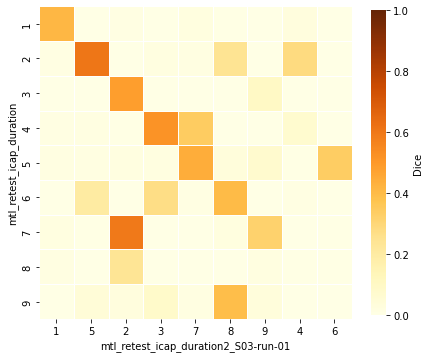

In [41]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset = 'mtl_retest'
all_splits = ["S02-run-01","S02-run-02","S03-run-01","S03-run-02","S07-run-01","S07-run-02","S09-run-01","S09-run-02","S10-run-01","S10-run-02","S14-run-01","S14-run-02"]

params_quant_retest_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':[all_splits[0]],'lthresh':1.6}
params_quant_retest_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': all_splits[1:4],'lthresh':1.6}

spine_analysis_retest = SpineOnlyAnalysis(config,params1=params_quant_retest_1,params2=params_quant_retest_2)
spine_analysis_retest.spatial_similarity(k1=9,t_range1=all_splits[0],t_range2=[all_splits[2]],similarity_method='Dice',save_figure=False,verbose=False)

<hr style="border:1px solid black">

# Figure S1 – QC

In [18]:
fd_df = pd.read_csv(config['main_dir'] + config['output_dir'] + 'fd_dataframe.csv',delimiter=",")

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks",  font='sans-serif')
fig = plt.figure()

colors=["#72ac3bff","#b0297dff"]
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="FD_mean",x="dataset",data=fd_df, kind="box", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
              boxprops=dict(alpha=.5,edgecolor=None),whiskerprops=dict(color=colors[0]),capprops=dict(color=colors[0]), fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(3,5)
g.set(ylim=(0, 0.20))

sns.stripplot(x="dataset", y="FD_mean",data=fd_df,
             size=5,palette=colors, alpha=.3, linewidth=0, edgecolor='white',dodge=True)
g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_FD.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

In [27]:
tsnr_df = pd.read_csv(config['main_dir'] + config['output_dir'] + 'tsnr_dataframe.csv',delimiter=",")

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks",  font='sans-serif')
fig = plt.figure()

colors=["#72ac3bff","#b0297dff"]
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="tsnr",x="dataset",data=tsnr_df, kind="box", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
              boxprops=dict(alpha=.5,edgecolor=None),whiskerprops=dict(color=colors[0]),capprops=dict(color=colors[0]), fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(3,5)
g.set(ylim=(0, 20))

sns.stripplot(x="dataset", y="tsnr",data=tsnr_df,
             size=5,palette=colors, alpha=.3, linewidth=0, edgecolor='white',dodge=True)
g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_tSNR.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>